In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from ALT_F_BIND_chromo_vertex_nuclear_competitive_2_density import *
# TODO- use hetero_ave

# h3k9me3, hp1

## load mark profile

In [4]:
# bigwig file from quinn bottom up paper, then converted to bedgraph using bigWigToBedGraph from UCSC command line tool on WSL
h3k9me3_data = pd.read_csv('output.bedGraph', sep="\t", header=None)
h3k9me3_data.columns = ["chromosome", "start", "end", "value"]


# isolate chromosome 16
chr16_h3k9me3_data = h3k9me3_data[h3k9me3_data["chromosome"] == "chr16"] #.groupby("chromosome")
chr16_h3k9me3_data.sort_values("start", inplace=True)


# convert matrix of ranges into 1d array
# 1. Determine the size of the array
array_size = chr16_h3k9me3_data['end'].max()

# 2. Initialize the 1D array with zeros
h3k9me3_signal_bp = np.zeros(array_size)

# 3. Use numpy's vectorized approach to fill the array
# For each row, we create a range from start to end and assign the value

# Create a mask for each range and use broadcasting
starts = chr16_h3k9me3_data['start'].values
ends = chr16_h3k9me3_data['end'].values
values = chr16_h3k9me3_data['value'].values

# Create an array of indices from all ranges using np.concatenate and np.arange
indices = np.concatenate([np.arange(s, e) for s, e in zip(starts, ends)])

# Repeat the values according to the length of each interval
repeated_values = np.repeat(values, ends - starts)

# Assign the values to the appropriate positions in result_array
np.add.at(h3k9me3_signal_bp, indices, repeated_values)

# Display the result
print(h3k9me3_signal_bp)
print(array_size)


# integrate (sum) over nucleosomes
bp_per_nuc = 200
trimmed_size = (h3k9me3_signal_bp.size // bp_per_nuc) * bp_per_nuc
# print(trimmed_size)
reshaped_arr = h3k9me3_signal_bp[:trimmed_size].reshape(-1, bp_per_nuc)

# 2. Sum along the rows (axis 1)
h3k9me3_signal_nuc = np.sum(reshaped_arr, axis=1)

C:\Users\tmhab\AppData\Local\Temp\ipykernel_47780\3228451858.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data.sort_values("start", inplace=True)


[0.   0.   0.   ... 0.56 0.56 0.56]
90294025


In [5]:
num_nucs = len(h3k9me3_signal_nuc)

one_mark_cutoff = 220
two_mark_cutoff = one_mark_cutoff*2
print("# NO mark nucs: ", np.sum(h3k9me3_signal_nuc<one_mark_cutoff))
print("# one mark nucs: ", np.sum(1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff)))
print("# two mark nucs: ", np.sum(h3k9me3_signal_nuc>=two_mark_cutoff))

marks_1 = np.zeros(num_nucs)

marks_1[np.where(h3k9me3_signal_nuc<one_mark_cutoff)] = 0
marks_1[np.where(1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff))] = 1
marks_1[np.where(h3k9me3_signal_nuc>=two_mark_cutoff)] = 2
# np.sum(h3k9me3_signal_nuc>=two_mark_cutoff)

# NO mark nucs:  189916
# one mark nucs:  99726
# two mark nucs:  161828


In [6]:
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# plt.plot(np.arange(len(h3k9me3_signal_nuc)), h3k9me3_signal_nuc, label = "ChIP-seq signal")
# plt.hlines(one_mark_cutoff, 0,1000, linestyle = "--", color = "black", label = "one mark threshold")
# plt.hlines(one_mark_cutoff*2, 0,1000, linestyle = "--", color = "red", label = "two mark threshold")

# # plt.scatter(np.arange(len(marks_1)), marks_1, label = "cutoff")

# # two_mark_cutoff = one_mark_/cutoff*2
# plt.xlim(950,1000)
# plt.ylim(0,2000)
# plt.xlabel("nucleosome position")
# plt.ylabel("H3K9me3 ChIP-seq signal")
# plt.legend()

In [7]:
# # plt.scatter(np.arange(len(h3k9me3_signal_nuc)), h3k9me3_signal_nuc, label = "raw")
# plt.scatter(np.arange(len(marks_1)), marks_1, label = "cutoff")
# # plt.ylim(0,200)
# plt.xlim(950,1000)

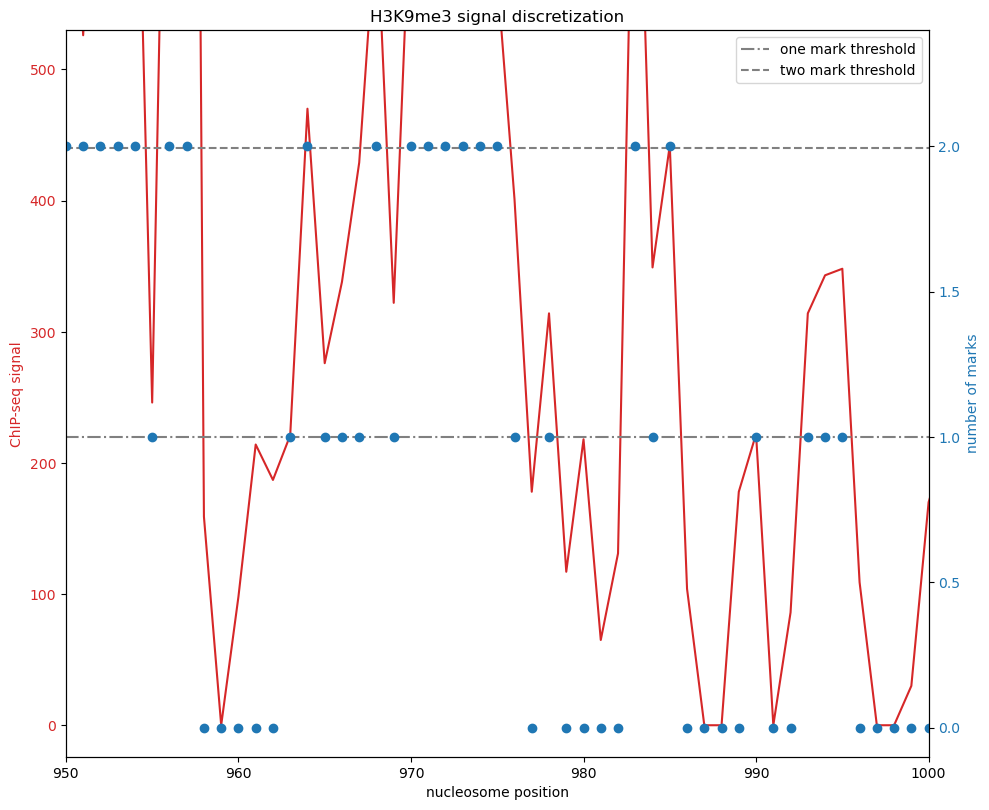

In [8]:
# plt.figure(figsize=(10,8))
# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)
fig, ax1 = plt.subplots(figsize=(10, 8))

plt.xlim(950,1000)
plt.ylim(-24,one_mark_cutoff*2+90)

color = 'tab:red'
ax1.set_xlabel('nucleosome position')
ax1.set_ylabel("ChIP-seq signal", color=color)
ax1.plot(np.arange(len(h3k9me3_signal_nuc)), h3k9me3_signal_nuc, color = color)
ax1.tick_params(axis='y', labelcolor=color)
plt.hlines(one_mark_cutoff, 0,1000, linestyle = "-.", color = "grey", label = "one mark threshold")
plt.hlines(one_mark_cutoff*2, 0,1000, linestyle = "--", color = "grey", label = "two mark threshold")
plt.legend(loc="upper right")

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
plt.ylim(-.1,2.4)
color = 'tab:blue'
ax2.set_ylabel('number of marks', color=color)  # we already handled the x-label with ax1
ax2.scatter(np.arange(len(marks_1)), marks_1, label = "cutoff")
ax2.tick_params(axis='y', labelcolor=color)

# plt.xlabel("nucleosome position")
# plt.ylabel("H3K9me3 ChIP-seq signal")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("H3K9me3 signal discretization")
plt.show()

## calculate binding states

### functions for transfer matrix method NOT AVERAGED

In [11]:
# def eval_tmat(mu_a, mu_b, ea1 = 0, ea2 = 0, eb1 = 0, eb2 = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
#     r"""
#     eval_tmat - Evaluate the transfer matrix or the nucleosome
    
#     Parameters
#     ----------
#     mu : float
#         HP1 chemical potential
#     nm1 : int
#         Number of methylated tails in the left-side nucleosome
#     nm2 : int
#         Number of methylated tails in the right-side nucleosome
#     nu : int
#         Indicator for nucleosomes within the interaction length
#     j_int : float
#         Strength of the HP1 interactions
    
#     Returns
#     -------
#     tmat : 3x3 float array
#         Transfer matrix for the nucleosome    
    
#     """
#     # boltzmann weightings of all possible binding states of the two nucleosommes. essentially all possible non-normalized joint probabilities
#     tmat = np.zeros((3,3))
#     for n1 in range(3):
#         for n2 in range(3):
#             if (n1 == 0 and n2 == 0):
#                 f_tot = 0.
#             elif (n1 == 0 and n2 == 1):
#                 f_tot = 0.5 * (-mu_a + ea2)
#             elif (n1 == 1 and n2 == 0):
#                 f_tot = 0.5 * (-mu_a + ea1)
#             elif (n1 == 0 and n2 == 2):
#                 f_tot = 0.5 * (-mu_b + eb2)
#             elif (n1 == 2 and n2 == 0):
#                 f_tot = 0.5 * (-mu_b + eb1)
#             elif (n1 == 1 and n2 == 1):
#                 f_tot = 0.5 * (-2 * mu_a + ea1 + ea2) + j_aa
#             elif (n1 == 1 and n2 == 2):
#                 f_tot = 0.5 * (-mu_a - mu_b + ea1 + eb2) + j_ab
#             elif (n1 == 2 and n2 == 1):
#                 f_tot = 0.5 * (-mu_a - mu_b + ea2 + eb1) + j_ab
#             elif (n1 == 2 and n2 == 2):
#                 f_tot = 0.5 * (-2 * mu_b + eb1 + eb2) + j_bb

#             f_tot -= f_ref
#             tmat[n1, n2] = np.exp(-f_tot)
                    
#     return tmat

# def eval_tend(mu_a, mu_b, ea = 0, eb = 0, f_ref = 0):
#     r"""
#     eval_tmat - Evaluate the transfer matrix or the nucleosome
    
#     Parameters
#     ----------
#     mu : float
#         HP1 chemical potential
#     nm1 : int
#         Number of methylated tails in the left-side nucleosome
#     nm2 : int
#         Number of methylated tails in the right-side nucleosome
#     nu : int
#         Indicator for nucleosomes within the interaction length
#     j_int : float
#         Strength of the HP1 interactions
    
#     Returns
#     -------
#     tmat : 3x3 float array
#         Transfer matrix for the nucleosome    
    
#     """
    
#     tend = np.zeros((3))
#     tend[0] = 1
    
#     f_tot = 0.5 * (-mu_a + ea)
#     f_tot -= f_ref
#     tend[1] = np.exp(-f_tot)

#     f_tot = 0.5 * (-mu_b + eb)
#     f_tot -= f_ref
#     tend[2] = np.exp(-f_tot)
                    
#     return tend

# def eval_dtdmu(mu_a, mu_b, ea1 = 0, ea2 = 0, eb1 = 0, eb2 = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
#     r"""
#     eval_tmat - Evaluate the transfer matrix or the nucleosome
    
#     Parameters
#     ----------
#     mu : float
#         HP1 chemical potential
#     nm1 : int
#         Number of methylated tails in the left-side nucleosome
#     nm2 : int
#         Number of methylated tails in the right-side nucleosome
#     nu : int
#         Indicator for nucleosomes within the interaction length
#     j_int : float
#         Strength of the HP1 interactions
    
#     Returns
#     -------
#     tmat : 3x3 float array
#         Transfer matrix for the nucleosome    
    
#     """
    
#     dtda1 = np.zeros((3,3))
#     dtda2 = np.zeros((3,3))
#     dtdb1 = np.zeros((3,3))
#     dtdb2 = np.zeros((3,3))
#     for n1 in range(3):
#         for n2 in range(3):
#             if (n1 == 0 and n2 == 0):
#                 f_tot = 0.
#                 f_tot -= f_ref
#             elif (n1 == 0 and n2 == 1):
#                 f_tot = 0.5 * (-mu_a + ea2)
#                 f_tot -= f_ref
#                 dtda2[n1, n2] = 0.5 * np.exp(-f_tot)
#             elif (n1 == 1 and n2 == 0):
#                 f_tot = 0.5 * (-mu_a + ea1)
#                 f_tot -= f_ref
#                 dtda1[n1, n2] = 0.5 * np.exp(-f_tot)
#             elif (n1 == 0 and n2 == 2):
#                 f_tot = 0.5 * (-mu_b + eb2)
#                 f_tot -= f_ref
#                 dtdb2[n1, n2] = 0.5 * np.exp(-f_tot)
#             elif (n1 == 2 and n2 == 0):
#                 f_tot = 0.5 * (-mu_b + eb1)
#                 f_tot -= f_ref
#                 dtdb1[n1, n2] = 0.5 * np.exp(-f_tot)
#             elif (n1 == 1 and n2 == 1):
#                 f_tot = 0.5 * (-2 * mu_a + ea1 + ea2) + j_aa
#                 f_tot -= f_ref
#                 dtda1[n1, n2] = 0.5 * np.exp(-f_tot)
#                 dtda2[n1, n2] = 0.5 * np.exp(-f_tot)
#             elif (n1 == 1 and n2 == 2):
#                 f_tot = 0.5 * (-mu_a - mu_b + ea1 + eb2) + j_ab
#                 f_tot -= f_ref
#                 dtda1[n1, n2] = 0.5 * np.exp(-f_tot)
#                 dtdb2[n1, n2] = 0.5 * np.exp(-f_tot)
#             elif (n1 == 2 and n2 == 1):
#                 f_tot = 0.5 * (-mu_a - mu_b + ea2 + eb1) + j_ab
#                 f_tot -= f_ref
#                 dtda2[n1, n2] = 0.5 * np.exp(-f_tot)
#                 dtdb1[n1, n2] = 0.5 * np.exp(-f_tot)
#             elif (n1 == 2 and n2 == 2):
#                 f_tot = 0.5 * (-2 * mu_b + eb1 + eb2) + j_bb
#                 f_tot -= f_ref
#                 dtdb1[n1, n2] = 0.5 * np.exp(-f_tot)
#                 dtdb2[n1, n2] = 0.5 * np.exp(-f_tot)
        
#     return dtda1, dtda2, dtdb1, dtdb2

# def eval_dtenddmu(mu_a, mu_b, ea = 0, eb = 0, f_ref = 0):
#     r"""
#     eval_tmat - Evaluate the transfer matrix or the nucleosome
    
#     Parameters
#     ----------
#     mu : float
#         HP1 chemical potential
#     nm1 : int
#         Number of methylated tails in the left-side nucleosome
#     nm2 : int
#         Number of methylated tails in the right-side nucleosome
#     nu : int
#         Indicator for nucleosomes within the interaction length
#     j_int : float
#         Strength of the HP1 interactions
    
#     Returns
#     -------
#     tmat : 3x3 float array
#         Transfer matrix for the nucleosome    
    
#     """
    
#     dtendda = np.zeros((3))
#     dtenddb = np.zeros((3))
    
#     f_tot = 0.5 * (-mu_a + ea)
#     f_tot -= f_ref
#     dtendda[1] = 0.5 * np.exp(-f_tot)

#     f_tot = 0.5 * (-mu_b + eb)
#     f_tot -= f_ref
#     dtenddb[2] = 0.5 * np.exp(-f_tot)
                    
#     return dtendda, dtenddb

# def eval_phi(sig, mu_a = 0, mu_b = 0, ea = 0, eb = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
    
#     nm = len(sig)
#     phiva = np.zeros((nm, 3))
#     phivb = np.zeros((nm, 3))
#     phia = np.zeros((nm))
#     phib = np.zeros((nm))
    
#     # Evaluate binding for the first bead
#     # print("first bead binding:")
#     ea2 = (1 - sig[0]) * ea
#     eb2 = sig[0] * eb
#     tend = eval_tend(mu_a, mu_b, ea2, eb2, f_ref)
#     # print("tend: ", tend)
#     dtendda, dtenddb = eval_dtenddmu(mu_a, mu_b, ea2, eb2, f_ref)
#     # print("dtend/dmu_a :", dtendda)
#     # print("dtend/dmu_b :", dtenddb)
    
#     q_vec = tend
#     # print("q_vec: ", q_vec)
    
#     phiva[0, :] = dtendda
#     phivb[0, :] = dtenddb
#     for j in range(1, nm):
#         phiva[j, :] = tend
#         phivb[j, :] = tend

#     # print("phiva: ", phiva)
#     # print("phivb: ", phivb)
    
#     # Evaluate binding for the intermediate beads
#     # print("intermediate bead binding:")
#     for i in range(0, nm - 1):
#         # print(" --- nucleosome %s ---" % str(i+1))
#         ea1 = ea2
#         eb1 = eb2
#         ea2 = (1 - sig[i + 1]) * ea
#         eb2 = sig[i + 1] * eb
        
#         tmat = eval_tmat(mu_a, mu_b, ea1, ea2, eb1, eb2, j_aa, j_bb, j_ab, f_ref)
#         # print("tmat: ", tmat)
#         dtda1, dtda2, dtdb1, dtdb2 = eval_dtdmu(mu_a, mu_b, ea1, ea2, eb1, eb2, j_aa, j_bb, j_ab, f_ref)
        
#         # print("dt/dmu_a1: ", dtda1)
#         # print("dt/dmu_a2: ", dtda2)
#         # print("dt/dmu_b1: ", dtdb1)
#         # print("dt/dmu_b2: ", dtdb2)
        
#         q_vec = np.matmul(q_vec, tmat) # collecting all possibilites for eventual full partition function

#         # print("updated q_vec (matmul q_vec and tmat): ", q_vec)
        
#         # # print(q_vec)
#         # print("old phiva: ", phiva)
#         # print("old phivb: ", phivb)
        
#         for j in range(0, nm):
#             if j == i:
#                 phiva[j, :] = np.matmul(phiva[j, :], tmat) + np.matmul(phiva[i + 1, :], dtda1)
#                 phivb[j, :] = np.matmul(phivb[j, :], tmat) + np.matmul(phivb[i + 1, :], dtdb1)
#             elif j == (i + 1):
#                 phiva[j, :] = np.matmul(phiva[j, :], dtda2)
#                 phivb[j, :] = np.matmul(phivb[j, :], dtdb2)
#             else:
#                 phiva[j, :] = np.matmul(phiva[j, :], tmat)
#                 phivb[j, :] = np.matmul(phivb[j, :], tmat)

#         # print("new phiva: ", phiva)
#         # print("new phivb: ", phivb)
    
#     # Evaluate binding for the last bead

#     # print("last bead binding:")
    
#     ea1 = ea2
#     eb1 = eb2

#     tend = eval_tend(mu_a, mu_b, ea1, eb1, f_ref)
#     dtendda, dtenddb = eval_dtenddmu(mu_a, mu_b, ea1, eb1, f_ref)

#     # print("tend: ", tend)
#     # print("dtendda, dtendda: ", dtendda, dtendda)

#     q = np.matmul(q_vec, tend)
#     phia[nm - 1] = (np.matmul(q_vec, dtendda) + np.matmul(phiva[nm - 1, :], tend)) / q
#     phib[nm - 1] = (np.matmul(q_vec, dtenddb) + np.matmul(phivb[nm - 1, :], tend)) / q
#     for j in range(0, nm - 1):
#         phia[j] = np.matmul(phiva[j, :], tend) / q
#         phib[j] = np.matmul(phivb[j, :], tend) / q
    
#     return phia, phib



In [12]:
#### calc binding not avgd

In [13]:
# %%time
# # not averaged!
# sig = marks_1#[:10]

# mu_hp1 = -3
# mu_prc1 = -1000
# ea = -1.52
# eb = 0

# j_aa = -4
# j_bb = 0
# j_ab = 0

# f_ref = np.min(np.array([j_aa, j_bb, j_ab, ea, eb]))
# phia, phib = eval_phi(sig, mu_hp1, mu_prc1, ea, eb, j_aa, j_bb, j_ab, f_ref)
# # phia, phib = eval_phi(sig, mu_hp1, mu_prc1, ea, eb)
# #5:42

### functions for binding averaged

In [15]:
def eval_tmat(mu_a, mu_b, pa1 = 1, pa2 = 1, ea = 0, eb = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    T: considereing all the possible binding state combinations of the nucleosome to the left and the right
        , all the contributions to the binding state partition function
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """
    
    v1 = np.array([1, np.sqrt(pa1) * np.exp(mu_a / 2 - ea / 2), np.sqrt(pa1) * np.exp(mu_b / 2), np.sqrt(1 - pa1) * np.exp(mu_a / 2), np.sqrt(1 - pa1) * np.exp(mu_b / 2 - eb / 2)])
    v2 = np.array([1, np.sqrt(pa2) * np.exp(mu_a / 2 - ea / 2), np.sqrt(pa2) * np.exp(mu_b / 2), np.sqrt(1 - pa2) * np.exp(mu_a / 2), np.sqrt(1 - pa2) * np.exp(mu_b / 2 - eb / 2)])
    tmat = np.outer(v1, v2) * np.exp(f_ref)
    # T: tmat is all possible combinations of (un-normalized) probability of adjacent nucleosomes binding state (boltzmann weightings)
    #   essentially joint probability matrix
    
    # Add the interaction terms
    # T: all the matrix elements with a 0 have at max one protein bound, therefore no interaction
    # T: QUESTION: tmat[1,1]] means left nucleosome and right nucleosome have A bound. why assume interaction between them then?
    # ANSWER: tmat is bbetween two nucleosomes total: left-side and right-side. propogating from left-side to right-side
    tmat[1, 1] *= np.exp(-j_aa)
    tmat[1, 2] *= np.exp(-j_ab)
    tmat[1, 3] *= np.exp(-j_aa)
    tmat[1, 4] *= np.exp(-j_ab)
    tmat[2, 1] *= np.exp(-j_ab)
    tmat[2, 2] *= np.exp(-j_bb)
    tmat[2, 3] *= np.exp(-j_ab)
    tmat[2, 4] *= np.exp(-j_bb)
    tmat[3, 1] *= np.exp(-j_aa)
    tmat[3, 2] *= np.exp(-j_ab)
    tmat[3, 3] *= np.exp(-j_aa)
    tmat[3, 4] *= np.exp(-j_ab)
    tmat[4, 1] *= np.exp(-j_ab)
    tmat[4, 2] *= np.exp(-j_bb)
    tmat[4, 3] *= np.exp(-j_ab)
    tmat[4, 4] *= np.exp(-j_bb)
                    
    return tmat

def eval_tend(mu_a, mu_b, pa = 1, ea = 0, eb = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    T: only have one interaction if nucleosome is first or last genomic position
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """

    v1 = np.array([1, np.sqrt(pa) * np.exp(mu_a / 2 - ea / 2), np.sqrt(pa) * np.exp(mu_b / 2), np.sqrt(1 - pa) * np.exp(mu_a / 2), np.sqrt(1 - pa) * np.exp(mu_b / 2 - eb / 2)])    
    
    tend = v1 * np.exp(f_ref)
                    
    return tend

def eval_dtdmu(mu_a, mu_b, pa1 = 1, pa2 = 1, ea = 0, eb = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """

    
    v1 = np.array([1, np.sqrt(pa1) * np.exp(mu_a / 2 - ea / 2), np.sqrt(pa1) * np.exp(mu_b / 2), np.sqrt(1 - pa1) * np.exp(mu_a / 2), np.sqrt(1 - pa1) * np.exp(mu_b / 2 - eb / 2)])
    # change in transfer matrix as change mu_a, mu_b wrt left nucleosome
    dv1da = np.array([0, 0.5 * np.sqrt(pa1) * np.exp(mu_a / 2 - ea / 2), 0, 0.5 * np.sqrt(1 - pa1) * np.exp(mu_a / 2), 0])
    dv1db = np.array([0, 0, 0.5 * np.sqrt(pa1) * np.exp(mu_b / 2), 0, 0.5 * np.sqrt(1 - pa1) * np.exp(mu_b / 2 - eb / 2)])
    
    v2 = np.array([1, np.sqrt(pa2) * np.exp(mu_a / 2 - ea / 2), np.sqrt(pa2) * np.exp(mu_b / 2), np.sqrt(1 - pa2) * np.exp(mu_a / 2), np.sqrt(1 - pa2) * np.exp(mu_b / 2 - eb / 2)])
    dv2da = np.array([0, 0.5 * np.sqrt(pa2) * np.exp(mu_a / 2 - ea / 2), 0, 0.5 * np.sqrt(1 - pa2) * np.exp(mu_a / 2), 0])
    dv2db = np.array([0, 0, 0.5 * np.sqrt(pa2) * np.exp(mu_b / 2), 0, 0.5 * np.sqrt(1 - pa2) * np.exp(mu_b / 2 - eb / 2)])
    
    dtda1 = np.outer(dv1da, v2) * np.exp(f_ref)
    dtdb1 = np.outer(dv1db, v2) * np.exp(f_ref)
    dtda2 = np.outer(v1, dv2da) * np.exp(f_ref)
    dtdb2 = np.outer(v1, dv2db) * np.exp(f_ref)
    
    # Add the interaction terms
    
    dtda1[1, 1] *= np.exp(-j_aa)
    dtda1[1, 2] *= np.exp(-j_ab)
    dtda1[1, 3] *= np.exp(-j_aa)
    dtda1[1, 4] *= np.exp(-j_ab)
    dtda1[2, 1] *= np.exp(-j_ab)
    dtda1[2, 2] *= np.exp(-j_bb)
    dtda1[2, 3] *= np.exp(-j_ab)
    dtda1[2, 4] *= np.exp(-j_bb)
    dtda1[3, 1] *= np.exp(-j_aa)
    dtda1[3, 2] *= np.exp(-j_ab)
    dtda1[3, 3] *= np.exp(-j_aa)
    dtda1[3, 4] *= np.exp(-j_ab)
    dtda1[4, 1] *= np.exp(-j_ab)
    dtda1[4, 2] *= np.exp(-j_bb)
    dtda1[4, 3] *= np.exp(-j_ab)
    dtda1[4, 4] *= np.exp(-j_bb)
    
    dtdb1[1, 1] *= np.exp(-j_aa)
    dtdb1[1, 2] *= np.exp(-j_ab)
    dtdb1[1, 3] *= np.exp(-j_aa)
    dtdb1[1, 4] *= np.exp(-j_ab)
    dtdb1[2, 1] *= np.exp(-j_ab)
    dtdb1[2, 2] *= np.exp(-j_bb)
    dtdb1[2, 3] *= np.exp(-j_ab)
    dtdb1[2, 4] *= np.exp(-j_bb)
    dtdb1[3, 1] *= np.exp(-j_aa)
    dtdb1[3, 2] *= np.exp(-j_ab)
    dtdb1[3, 3] *= np.exp(-j_aa)
    dtdb1[3, 4] *= np.exp(-j_ab)
    dtdb1[4, 1] *= np.exp(-j_ab)
    dtdb1[4, 2] *= np.exp(-j_bb)
    dtdb1[4, 3] *= np.exp(-j_ab)
    dtdb1[4, 4] *= np.exp(-j_bb)
                    
    dtda2[1, 1] *= np.exp(-j_aa)
    dtda2[1, 2] *= np.exp(-j_ab)
    dtda2[1, 3] *= np.exp(-j_aa)
    dtda2[1, 4] *= np.exp(-j_ab)
    dtda2[2, 1] *= np.exp(-j_ab)
    dtda2[2, 2] *= np.exp(-j_bb)
    dtda2[2, 3] *= np.exp(-j_ab)
    dtda2[2, 4] *= np.exp(-j_bb)
    dtda2[3, 1] *= np.exp(-j_aa)
    dtda2[3, 2] *= np.exp(-j_ab)
    dtda2[3, 3] *= np.exp(-j_aa)
    dtda2[3, 4] *= np.exp(-j_ab)
    dtda2[4, 1] *= np.exp(-j_ab)
    dtda2[4, 2] *= np.exp(-j_bb)
    dtda2[4, 3] *= np.exp(-j_ab)
    dtda2[4, 4] *= np.exp(-j_bb)
    
    dtdb2[1, 1] *= np.exp(-j_aa)
    dtdb2[1, 2] *= np.exp(-j_ab)
    dtdb2[1, 3] *= np.exp(-j_aa)
    dtdb2[1, 4] *= np.exp(-j_ab)
    dtdb2[2, 1] *= np.exp(-j_ab)
    dtdb2[2, 2] *= np.exp(-j_bb)
    dtdb2[2, 3] *= np.exp(-j_ab)
    dtdb2[2, 4] *= np.exp(-j_bb)
    dtdb2[3, 1] *= np.exp(-j_aa)
    dtdb2[3, 2] *= np.exp(-j_ab)
    dtdb2[3, 3] *= np.exp(-j_aa)
    dtdb2[3, 4] *= np.exp(-j_ab)
    dtdb2[4, 1] *= np.exp(-j_ab)
    dtdb2[4, 2] *= np.exp(-j_bb)
    dtdb2[4, 3] *= np.exp(-j_ab)
    dtdb2[4, 4] *= np.exp(-j_bb)
        
    return dtda1, dtda2, dtdb1, dtdb2
    
def eval_dtenddmu(mu_a, mu_b, pa = 1, ea = 0, eb = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """

    
    dv1da = np.array([0, 0.5 * np.sqrt(pa) * np.exp(mu_a / 2 - ea / 2), 0, 0.5 * np.sqrt(1 - pa) * np.exp(mu_a / 2), 0])
    dv1db = np.array([0, 0, 0.5 * np.sqrt(pa) * np.exp(mu_b / 2), 0, 0.5 * np.sqrt(1 - pa) * np.exp(mu_b / 2 - eb / 2)])
    
    dtendda = dv1da * np.exp(f_ref)
    dtenddb = dv1db * np.exp(f_ref)
                    
    return dtendda, dtenddb
    
def eval_phi(pa_vec, mu_a = 0, mu_b = 0, ea = 0, eb = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
    
    nm = len(pa_vec)
    phiva = np.zeros((nm, 5))
    phivb = np.zeros((nm, 5))
    phia = np.zeros((nm))
    phib = np.zeros((nm))
    
    # Evaluate binding for the first bead
    
    pa2 = pa_vec[0]
    tend = eval_tend(mu_a, mu_b, pa2, ea, eb, f_ref)
    dtendda, dtenddb = eval_dtenddmu(mu_a, mu_b, pa2, ea, eb, f_ref)

    q_vec = tend
    phiva[0, :] = dtendda
    phivb[0, :] = dtenddb
    for j in range(1, nm):
        phiva[j, :] = tend
        phivb[j, :] = tend
    
    # Evaluate binding for the intermediate beads
    
    for i in range(0, nm - 1):

        # update mark probabilty of left and right nucleosome
        pa1 = pa2
        pa2 = pa_vec[i + 1]
        
        tmat = eval_tmat(mu_a, mu_b, pa1, pa2, ea, eb, j_aa, j_bb, j_ab, f_ref)
        dtda1, dtda2, dtdb1, dtdb2 = eval_dtdmu(mu_a, mu_b, pa1, pa2, ea, eb, j_aa, j_bb, j_ab, f_ref)
        
        q_vec = np.matmul(q_vec, tmat)

        for j in range(0, nm):
            if j == i:
                phiva[j, :] = np.matmul(phiva[j, :], tmat) + np.matmul(phiva[i + 1, :], dtda1)
                phivb[j, :] = np.matmul(phivb[j, :], tmat) + np.matmul(phivb[i + 1, :], dtdb1)
            elif j == (i + 1):
                # only condiser neighbor in one direction- whole point of transfer matrix method
                phiva[j, :] = np.matmul(phiva[j, :], dtda2)
                phivb[j, :] = np.matmul(phivb[j, :], dtdb2)
            else:
                phiva[j, :] = np.matmul(phiva[j, :], tmat)
                phivb[j, :] = np.matmul(phivb[j, :], tmat)
    
    # Evaluate binding for the last bead

    pa1 = pa2
    tend = eval_tend(mu_a, mu_b, pa1, ea, eb, f_ref)
    dtendda, dtenddb = eval_dtenddmu(mu_a, mu_b, pa1, ea, eb, f_ref)

    # calculate average binding fractions
    q = np.matmul(q_vec, tend) #part func
    phia[nm - 1] = (np.matmul(q_vec, dtendda) + np.matmul(phiva[nm - 1, :], tend)) / q
    phib[nm - 1] = (np.matmul(q_vec, dtenddb) + np.matmul(phivb[nm - 1, :], tend)) / q
    for j in range(0, nm - 1):
        phia[j] = np.matmul(phiva[j, :], tend) / q
        phib[j] = np.matmul(phivb[j, :], tend) / q
    
    return phia, phib
    

def calc_binding_states(chrom):
    # evaluate average binding state for each nucleosome at each mu1,mu2
    
    [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    [pa_vec, marks_2] = poly_marks

    mu1_array = np.arange(mu_min, mu_max, del_mu)#[-5]
    mu2_array = np.arange(mu_min, mu_max, del_mu)#[-5]

    s_bind_1_soln_arr = np.zeros((len(mu1_array), len(mu2_array), M))
    s_bind_2_soln_arr = np.zeros((len(mu1_array), len(mu2_array), M))
    
    f_ref = np.min(np.array([v_int[0,0], v_int[1,1], v_int[0,1], e_m[0] / 2,  e_m[1] / 2]))

    for i, mu1 in enumerate(mu1_array):
        for j, mu2 in enumerate(mu2_array):
            s_bind_ave_a, s_bind_ave_b = eval_phi(pa_vec, mu1, mu2, e_m[0], e_m[1], v_int[0,0], v_int[1,1], v_int[0,1], f_ref)
            s_bind_1_soln_arr[i,j,:] = s_bind_ave_a
            s_bind_2_soln_arr[i,j,:] = s_bind_ave_b
    
    return s_bind_1_soln_arr, s_bind_2_soln_arr

### calculate binding averaged

In [17]:
binding_resolution = 1e6 #1mb
nuc_per_bin = int(binding_resolution / (bp_per_nuc)) # nuc per bin.    [resolution] = bp per bin, bp_per_nuc = 200

In [18]:
%%time
# AVERAGED
mlp_data_mark_1 = marks_1[:(len(marks_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)#.astype(sigma_dt)
mark_1_avgd = np.mean(mlp_data_mark_1, axis=1)

sig = mark_1_avgd/2 # should be from 0 to 1; percent marked#[:10]
mu_hp1 = -5
mu_prc1 = -1000
ea = -1.52
eb = 0#-1.52

j_aa = -4
j_bb = 0
j_ab = 0

f_ref = np.min(np.array([j_aa, j_bb, j_ab, ea, eb]))
s_bind_hp1_avgd, phib = eval_phi(sig, mu_hp1, mu_prc1, ea, eb, j_aa, j_bb, j_ab, f_ref)

CPU times: total: 15.6 ms
Wall time: 104 ms


In [19]:
s_bind_hp1_avgd, mark_1_avgd

(array([0.10736815, 0.20182971, 0.29619064, 0.39328223, 0.46485232,
        0.55969587, 0.63202996, 0.67008283, 0.6794615 , 0.69014483,
        0.69916143, 0.69105143, 0.68778497, 0.68688599, 0.66451331,
        0.64528278, 0.64106916, 0.64161973, 0.62496138, 0.61136993,
        0.60269686, 0.59420704, 0.58344224, 0.57040719, 0.55156205,
        0.52851006, 0.51144292, 0.49356226, 0.47073414, 0.47108172,
        0.4799001 , 0.50195411, 0.50074921, 0.45081437, 0.34498101,
        0.18856828, 0.07708674, 0.03766526, 0.02374487, 0.0188848 ,
        0.01734504, 0.01730707, 0.01872601, 0.02327774, 0.0363381 ,
        0.07333209, 0.17795168, 0.2831517 , 0.35521979, 0.40407727,
        0.44521723, 0.46738879, 0.48797287, 0.51486522, 0.52875608,
        0.53679278, 0.55237508, 0.56940451, 0.58965584, 0.61929035,
        0.64155454, 0.65131843, 0.64857993, 0.63404066, 0.62312128,
        0.6026895 , 0.57259864, 0.55164277, 0.55229384, 0.54805452,
        0.55339377, 0.57761665, 0.59103326, 0.59

<Figure size 640x480 with 0 Axes>

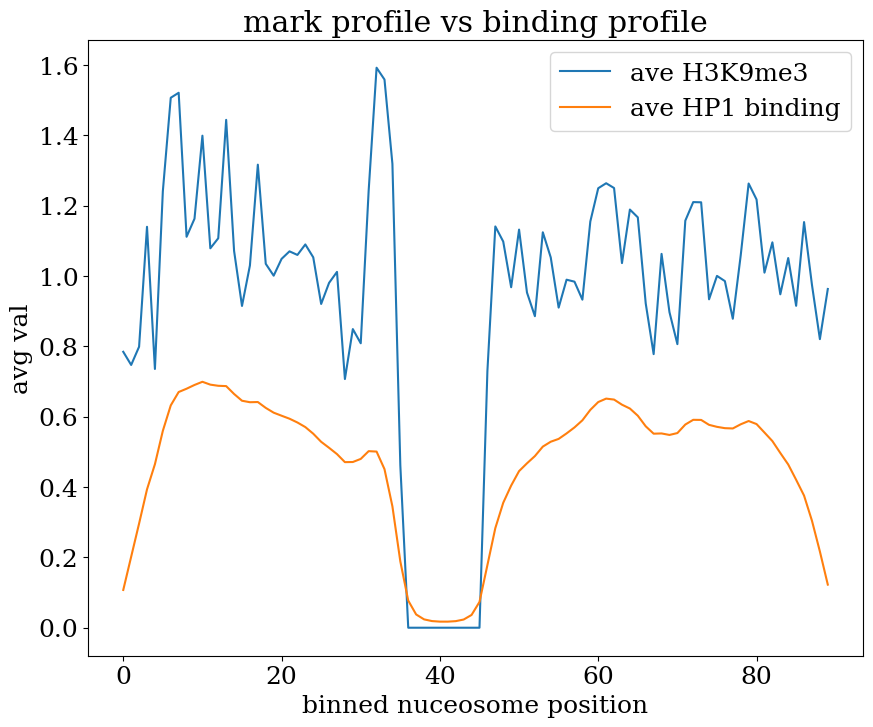

In [20]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(np.arange(len(s_bind_hp1_avgd)), mark_1_avgd, label = "ave H3K9me3")
plt.plot(np.arange(len(s_bind_hp1_avgd)), s_bind_hp1_avgd, label = "ave HP1 binding")

plt.xlabel("binned nuceosome position")
plt.ylabel("avg val")
plt.title("mark profile vs binding profile")
plt.legend()

## Hi-C

In [22]:
resolution = 1e6 #1mb
assert(binding_resolution == resolution)
Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.RAWobserved", sep="\t", header=None)
Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.KRnorm")
# Hi_c_raw_exp = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.RAWexpected", sep="\t", header=None)
# Hi_c_raw_exp.columns = ["i","j",r"$M_{ij}$"]
Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.KRexpected")

# resolution = 500e3 #500kb
# binding_resolution == resolution
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_500kb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_500kb.KRnorm")
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_500kb.KRexpected")

# resolution = 100e3 #100kb
# binding_resolution == resolution
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_100kb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_100kb.KRnorm")
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_100kb.KRexpected")

# resolution = 50e3 #50kb
# binding_resolution == resolution
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_50kb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_50kb.KRnorm")
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_50kb.KRexpected")

# resolution = 5e3 #5kb
# binding_resolution == resolution
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_5kb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_5kb.KRnorm")
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_5kb.KRexpected")

In [142]:
assert(binding_resolution == resolution)

### KR normalization of observed Hi-C data

In [24]:
Hi_c_Kr_obs = Hi_c_raw_obs[r"$M_{ij}$"].values / (Hi_c_KRnorm[(Hi_c_raw_obs["i"].values // resolution).astype(int)]*Hi_c_KRnorm[(Hi_c_raw_obs["j"].values // resolution).astype(int)])

In [25]:
Hi_c_raw_obs[r"$M_{ij}^{KR}$"] = Hi_c_Kr_obs

### Obs/Exp

In [27]:
# observed/expected correction
i_j_diff = Hi_c_raw_obs["i"].values - Hi_c_raw_obs["j"].values
Kr_indices = (i_j_diff // resolution).astype(int)
Hi_c_Kr_OE = Hi_c_Kr_obs / Hi_c_KRexpected[Kr_indices]
Hi_c_raw_obs[r"$(O/E)^{KR}$"] = Hi_c_Kr_OE

<Figure size 640x480 with 0 Axes>

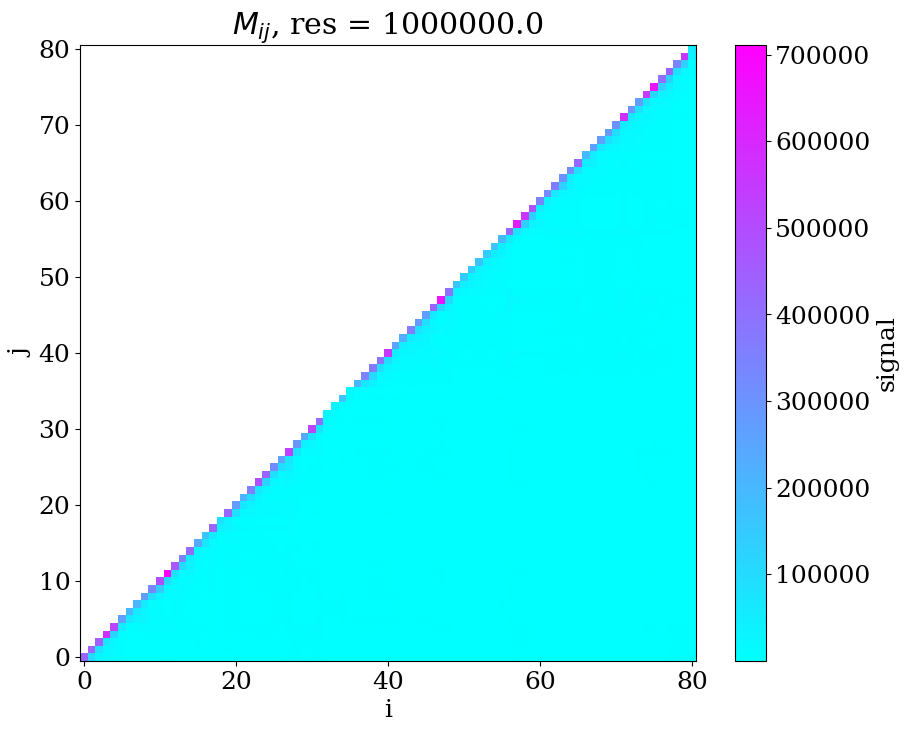

In [28]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r'$M_{ij}$')

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap='cool', interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'$M_{ij}$, res = %s' % resolution)

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

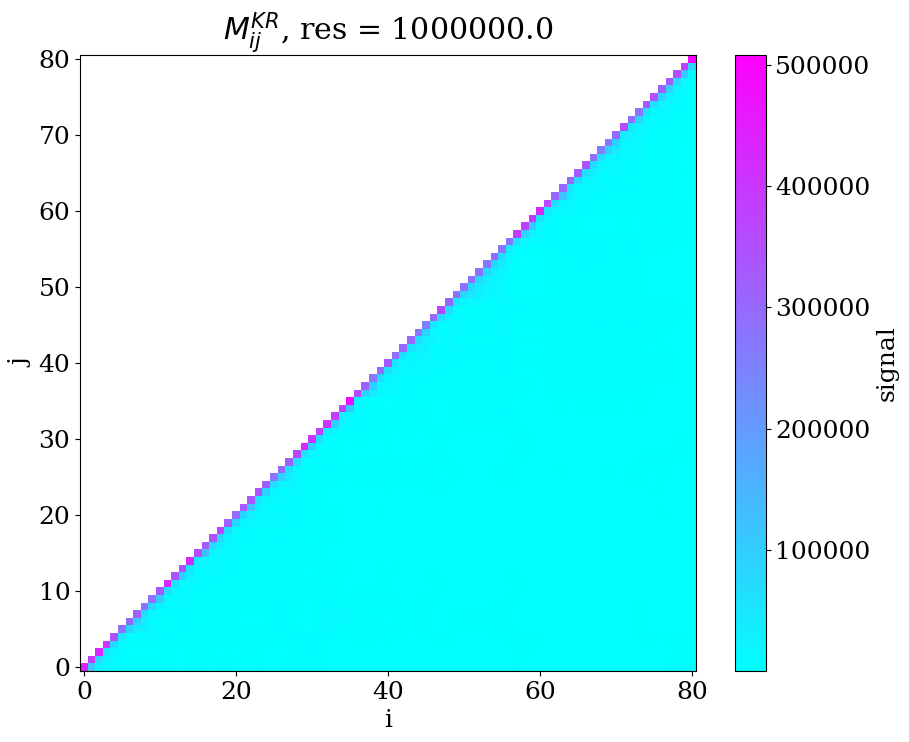

In [29]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r'$M_{ij}^{KR}$')

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap='cool', interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'$M_{ij}^{KR}$, res = %s' % resolution)

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

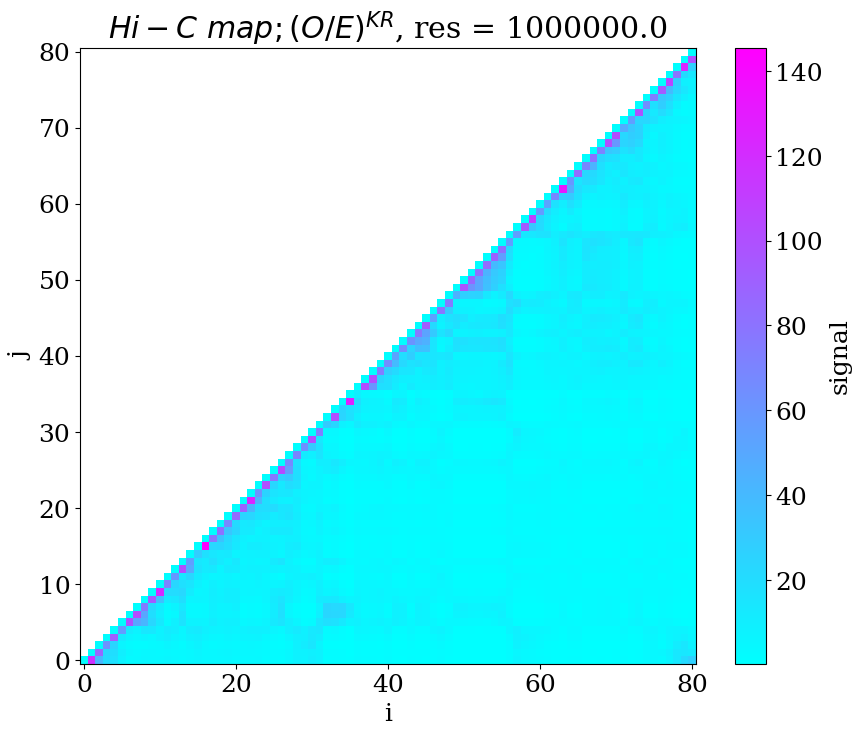

In [30]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r"$(O/E)^{KR}$")

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap="cool", interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r"$Hi-C \ map; (O/E)^{KR}$, res = %s" % resolution)

# Show the plot
plt.show()

In [31]:
# nuc_per_bin = int(resolution / (bp_per_nuc)) # nuc per bin.    [resolution] = bp per bin, bp_per_nuc = 200

# # generate copy of Hi-c data where genomic position turned into {bin index precursor}
# Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
# Hi_c_raw_obs_div = Hi_c_raw_obs_div.dropna()
# Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs_div["i"].values//resolution).astype(int)
# Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs_div["j"].values//resolution).astype(int)

# #cutoff last bin so that mark data and hi-c data are same size
# cutoff_bin = len(marks_1)//nuc_per_bin
# Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["i"] != cutoff_bin]
# Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["j"] != cutoff_bin]

# i_combs = Hi_c_raw_obs_div["i"].values
# j_combs = Hi_c_raw_obs_div["j"].values
# Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

# #Turn Hi_C data into binary classification; 1 = contact, 0 = no
# s_ij = np.zeros(len(Hi_C))
# s_ij[Hi_C > np.mean(Hi_C)] = 1 # Hi_C into binary classification, based on MEDIAN


## Logistic regression

Can define a cost function $J = \sum_{ij} (s_{ij} - f_{ij})^2$ where $s_{ij}$ is the true Hi-C observation for the ijth bin and $f_{ij}$ is the output of the activation function (sigmoid) for the same bin. 
$f_{ij}(b_{ij}) = \frac{1}{1+\exp(-b_{ij})}$ is a function of the ijth mark array $b_{ij} = \vec{\sigma}_i \mathbf{A} \vec{\sigma}_j + A_0$, where $\sigma_i$ is the mark profile vector and $\mathbf{A}$ is a matrix and $A_0$ is a scalar, both of which need to be "learned".

10/24 EDIT:  $\sigma_i$ is the mark profile vector, as in each entry is the averaged mark content for a specific mark type [h3k9me3, h3k27me3, ...]

In [34]:

# faster einsum
def func_dot_einsum(A, sig_i, sig_j):
    Y = sig_i.dot(A)
    return np.einsum('ij,ij->i', Y, sig_j)

# A_0 = 0
# WHERE sigma is array of averaged mark 
def cost_function(As, params):
    # num_marks = 1
    [sig_i_avgd, sig_j_avgd, s_ij, num_marks] = params
    # num_marks = np.shape(sig_i_avgd)[1]
    # sig_i_avgd = np.mean(sig_i, axis=1)
    # sig_j_avgd = np.mean(sig_j, axis=1)
    
    A_0 = As[-1]
    A_mat = As[0:len(As)-1].reshape(num_marks, num_marks)
    
    # b_ij = np.diag(np.matmul(np.matmul(sig_i, A_mat),sig_j.T)) + A_0 # mat mul, but only want diagonal compenents due to sig_i, sig_j being 2D, USELESS
    # b_ij = np.sum(np.matmul(sig_i, A_mat) * sig_j, axis=1) + A_0 # alt way of mat mul withoug large matrix creation, USELESS
    # b_ij = np.einsum("ij,jk,ik->i", sig_i, A_mat, sig_j) + A_0 # low mem, GOOD FOR 5kb
    # b_ij = func_dot_einsum(A_mat, sig_i_avgd, sig_j_avgd) + A_0 # faster hybrid of einsum, again memory issue; GOOD FOR 10kb AND ABOVE

    if num_marks == 1:
        # sig_i_avgd = sig_i_avgd_1
        # sig_j_avgd = sig_j_avgd_1
        b_ij = sig_i_avgd*A_mat[0]*sig_j_avgd+A_0
        # print(b_ij)
    else:
        A_mat[1,0] = A_mat[0,1] #enforce symmetry

        # sig_i_avgd =  np.vstack((sig_i_avgd_1, sig_i_avgd_2)).T
        # sig_j_avgd =  np.vstack((sig_j_avgd_1, sig_j_avgd_2)).T
        
        # b_ij = np.sum(np.matmul(sig_i_avgd.T, A_test) *sig_j_avgd.T, axis = 1) + A_0
        b_ij = np.einsum("ij,jk,ik->i", sig_i_avgd, A_mat, sig_j_avgd) + A_0 # low mem, GOOD FOR 5kb
        # b_ij = func_dot_einsum(A_mat, sig_i_avgd, sig_j_avgd) + A_0 # faster hybrid of einsum, again memory issue; GOOD FOR 10kb AND ABOVE

    f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid

    # J = np.sum((s_ij - f_ij)**2) 

    classified = np.zeros(len(f_ij))
    classified[f_ij > 0.5] = 1
    J = np.sum((s_ij - classified)**2) 
    return J


def simulated_annealing(objective, params, bounds, n_iterations, step_size, temp):
     # generate an initial point
     best = bounds#bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
     # evaluate the initial point
     best_eval = objective(best, params)
     # current working solution
     curr, curr_eval = best, best_eval
     # run the algorithm
     for i in range(n_iterations):
         # take a step
         cur_step = step_size/np.log(i+np.e) # decreasing step_size at iterations increase
         candidate = curr + np.random.randn(len(bounds)) * cur_step#step_size
         candidate_eval = objective(candidate, params)
         
         # check for new best solution
         if candidate_eval < best_eval:
             # store new best point
             best, best_eval = candidate, candidate_eval
             # report progress
             print('>%d f() = %.5f' % (i, best_eval))
             
         # difference between candidate and current point evaluation
         diff = candidate_eval - curr_eval
         # calculate temperature for current epoch
         # t = temp / float(i + 1) #linear
         t = temp/np.log(i+np.e) #log
         
         # calculate metropolis acceptance criterion
         metropolis = np.exp(-diff / t)
         # check if we should keep the new point
         if diff < 0 or np.random.rand() < metropolis:
             # store the new current point
             curr, curr_eval = candidate, candidate_eval
             
     return [best, best_eval]

In [247]:
nuc_per_bin

5000

In [61]:
nuc_per_bin = int(resolution / (bp_per_nuc)) # nuc per bin.    [resolution] = bp per bin, bp_per_nuc = 200

# generate copy of Hi-c data where genomic position turned into {bin index precursor}
Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
Hi_c_raw_obs_div = Hi_c_raw_obs_div.dropna()
Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs_div["i"].values//resolution).astype(int)
Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs_div["j"].values//resolution).astype(int)

#cutoff last bin so that mark data and hi-c data are same size
cutoff_bin = len(marks_1)//nuc_per_bin
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["i"] != cutoff_bin]
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["j"] != cutoff_bin]

i_combs = Hi_c_raw_obs_div["i"].values
j_combs = Hi_c_raw_obs_div["j"].values
Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

#Turn Hi_C data into binary classification; 1 = contact, 0 = no
s_ij = np.zeros(len(Hi_C))
s_ij[Hi_C > np.mean(Hi_C)] = 1 # Hi_C into binary classification, based on MEDIAN

# # first divide mark data into bins
# mlp_data_mark_1 = marks_1[:(len(marks_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)#.astype(sigma_dt)


# # get average mark signal for each bin
# sig_i_avgd_1 = np.mean(sig_i, axis=1)
# sig_j_avgd_1 = np.mean(sig_j, axis=1)

num_marks = 1

sig_mark_i = mark_1_avgd[i_combs]
sig_mark_j = mark_1_avgd[j_combs]

sig_bind_i = s_bind_hp1_avgd[i_combs] 
sig_bind_j = s_bind_hp1_avgd[j_combs]




# calculate b_ij. should a 1d vector len = len(Hi-C) Old def of sigma
# b_ij = np.diag(np.matmul(np.matmul(sig_i, A),sig_j.T)) + A_0 # mat mul, but only want diagonal compenents due to sig_i, sig_j beind 2D
# b_ij = np.sum(np.matmul(sig_i, A) * sig_j, axis=1) + A_0 # alt way of mat mul withoug large matrix creation
# b_ij = np.einsum("ij,jk,ik->i", sig_i, A, sig_j) + A_0 # simplest way, but slow due ot einsum inner workings- no intermediate array stored! https://stackoverflow.com/questions/20149201/why-is-numpys-einsum-slower-than-numpys-built-in-functions
# b_ij = func_dot_einsum(A, sig_i, sig_j) # faster hybrid of einsum, again memory issue

# calc b_ij. CORRECT DEF OF SIGMA

#single A matrix to describe all pairs

A = np.zeros((num_marks, num_marks))
A_0 = 0

if num_marks == 1:
    b_ij_mark = sig_mark_i*A[0]*sig_mark_i+A_0
    b_ij_bind = sig_bind_i*A[0]*sig_bind_i+A_0
    # print(b_ij)
else:
    raise Exception("only 1 mark implemented")

f_ij_mark = 1/(1 + np.exp(-b_ij_mark)) #sigmoid
f_ij_bind = 1/(1 + np.exp(-b_ij_bind)) #sigmoid

J_mark = np.sum((s_ij - f_ij_mark)**2) # cost function. CANT instead do maximum likelihood approach b/c points are not independent
J_bind = np.sum((s_ij - f_ij_bind)**2) # cost function. could instead do maximum likelihood approach b/c points are not independent

In [63]:
sig_bind_i * sig_bind_j

array([0.01152792, 0.02167008, 0.04073523, ..., 0.03726343, 0.02656267,
       0.01501271])

In [69]:
.10736815*.10736815

0.011527919634422498

In [67]:
sig_bind_j

array([0.10736815, 0.20182971, 0.20182971, ..., 0.12252635, 0.12252635,
       0.12252635])

In [65]:
sig_bind_i

array([0.10736815, 0.10736815, 0.20182971, ..., 0.30412586, 0.21679149,
       0.12252635])

<Figure size 640x480 with 0 Axes>

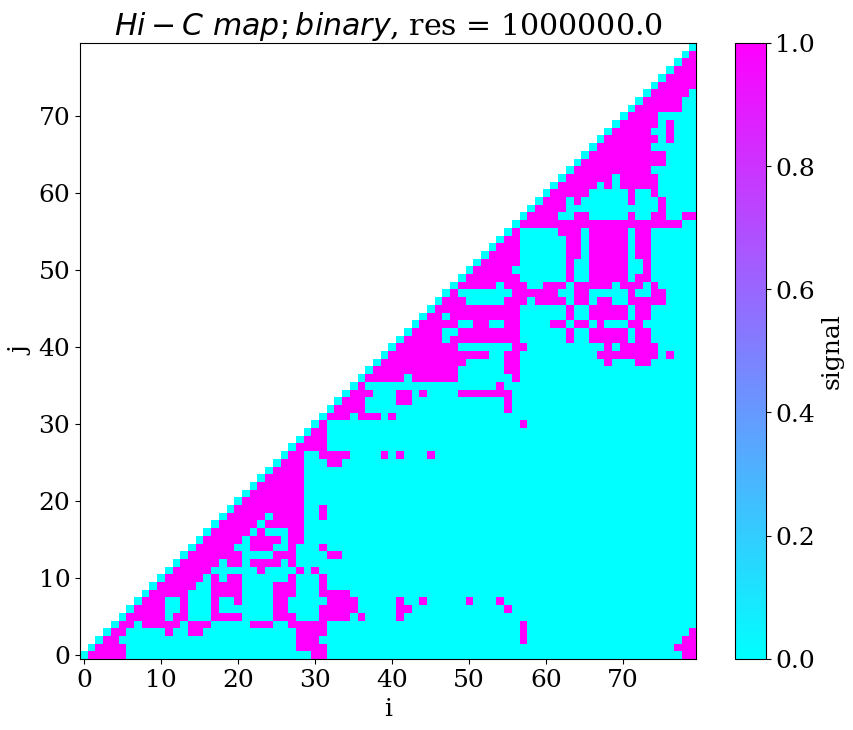

In [82]:
Hi_c_raw_obs_div[r"s_{ij}"] = s_ij

fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs_div.pivot(columns='j', index='i', values=r"s_{ij}")

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap="cool", interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r"$Hi-C \ map; binary$, res = %s" % resolution)

# Show the plot
plt.show()

In [84]:
s_ij

array([0., 1., 0., ..., 1., 1., 0.])

In [75]:
np.unique(i_combs) == np.unique(j_combs)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [77]:
# memory reduction


# i_combs_uniq = np.unique(i_combs)
# j_combs_uniq = np.unique(j_combs)


# # need to ensure i and j same lenth, and that all pairs considedered are valid in Hi-C matrix
# if len(i_combs_uniq) > len(j_combs_uniq):
#     less_uniq = j_combs#_uniq
# else:
#     less_uniq = i_combs#_uniq

# i_combs_uniq = less_uniq
# j_combs_uniq = less_uniq

# num_marks = 1

# sig_mark_i = mark_1_avgd[i_combs_uniq]
# sig_mark_j = mark_1_avgd[j_combs_uniq]

# sig_bind_i = s_bind_hp1_avgd[i_combs_uniq] 
# sig_bind_j = s_bind_hp1_avgd[j_combs_uniq]

sig_mark_i = mark_1_avgd[i_combs]
sig_mark_j = mark_1_avgd[j_combs]

sig_bind_i = s_bind_hp1_avgd[i_combs] 
sig_bind_j = s_bind_hp1_avgd[j_combs]

As = np.zeros(num_marks**2+1)# Initial guess.


params_uniq_mark = [sig_mark_i, sig_mark_j, s_ij, num_marks]   
params_uniq_bind = [sig_bind_i, sig_bind_j, s_ij, num_marks]   

step_size = 10
n_iter = 1000
temp = 1000000
# best, best_eval = simulated_annealing(cost_function, params_uniq, As,n_iter,step_size,temp)

best_mark, best_eval_mark = simulated_annealing(cost_function, params_uniq_mark, As,n_iter,step_size,temp)
best_bind, best_eval_bind = simulated_annealing(cost_function, params_uniq_bind, As,n_iter,step_size,temp)
#TODO: either change s_ij to a 2d matrix or b_ij into 1d arrays with all points of 2d matrix. think latter is easier

In [79]:
A_0_best_mark = best_mark[-1]
A_mat_best_mark = best_mark[0:len(best_mark)-1].reshape(num_marks, num_marks)

A_0_best_bind = best_bind[-1]
A_mat_best_bind = best_bind[0:len(best_bind)-1].reshape(num_marks, num_marks)

b_ij_mark = (sig_mark_i*A_mat_best_mark[0]*sig_mark_j)+A_0_best_mark
b_ij_bind = (sig_bind_i*A_mat_best_bind[0]*sig_bind_i)+A_0_best_bind


f_ij_mark = 1/(1 + np.exp(-b_ij_mark)) #sigmoid
f_ij_bind = 1/(1 + np.exp(-b_ij_bind)) #sigmoid


classified_mark = np.zeros(len(f_ij_mark))
classified_mark[f_ij_mark > 0.5] = 1

classified_bind = np.zeros(len(f_ij_bind))
classified_bind[f_ij_bind > 0.5] = 1

# R2 for regression
# SS_res = np.sum((s_ij - classified)**2)
# SS_tot = np.sum((s_ij - np.mean(s_ij))**2)

# R2 = 1 - (SS_res/SS_tot) # cost function. could instead do maximum likelihood approach
# R2
# print("NOT GOOD METRIC FOR CLASSIFICATION")


# # BIND confusion matrix
# true_pos_bind  = np.sum((s_ij == np.ones(len(s_ij))) * (classified_bind   == np.ones(len(s_ij))))
# true_neg_bind  = np.sum((s_ij == np.zeros(len(s_ij))) * (classified_bind   == np.zeros(len(s_ij))))
# false_pos_bind  = np.sum((s_ij == np.zeros(len(s_ij))) * (classified_bind   == np.ones(len(s_ij))))
# false_neg_bind  = np.sum((s_ij == np.ones(len(s_ij))) * (classified_bind   == np.zeros(len(s_ij))))

# recall_bind  = true_pos_bind  / (true_pos_bind  + false_neg_bind ) #sensitivity
# precision_bind  = true_pos_bind  / (true_pos_bind  + false_pos_bind ) 

# f1_bind   = (2 * precision_bind  * recall_bind ) / (precision_bind  + recall_bind )
# # f1_mark

# accuracy_bind   = (true_pos_bind  + true_neg_bind ) / (true_pos_bind  + true_neg_bind  + false_pos_bind  + false_neg_bind)


# MARK confusion matrix
true_pos_mark = np.sum((s_ij == np.ones(len(s_ij))) * (classified_mark == np.ones(len(s_ij))))
true_neg_mark = np.sum((s_ij == np.zeros(len(s_ij))) * (classified_mark == np.zeros(len(s_ij))))
false_pos_mark = np.sum((s_ij == np.zeros(len(s_ij))) * (classified_mark == np.ones(len(s_ij))))
false_neg_mark = np.sum((s_ij == np.ones(len(s_ij))) * (classified_mark == np.zeros(len(s_ij))))

recall_mark = true_pos_mark / (true_pos_mark + false_neg_mark) #sensitivity
precision_mark = true_pos_mark / (true_pos_mark + false_pos_mark) 

f1_mark = (2 * precision_mark * recall_mark) / (precision_mark + recall_mark)
# f1_bind
accuracy_mark = (true_pos_mark + true_neg_mark) / (true_pos_mark + true_neg_mark + false_pos_mark + false_neg_mark)

# BIND confusion matrix
true_pos_bind  = np.sum((s_ij == np.ones(len(s_ij))) * (classified_bind   == np.ones(len(s_ij))))
true_neg_bind  = np.sum((s_ij == np.zeros(len(s_ij))) * (classified_bind   == np.zeros(len(s_ij))))
false_pos_bind  = np.sum((s_ij == np.zeros(len(s_ij))) * (classified_bind   == np.ones(len(s_ij))))
false_neg_bind  = np.sum((s_ij == np.ones(len(s_ij))) * (classified_bind   == np.zeros(len(s_ij))))

recall_bind  = true_pos_bind  / (true_pos_bind  + false_neg_bind ) #sensitivity
precision_bind  = true_pos_bind  / (true_pos_bind  + false_pos_bind ) 

f1_bind   = (2 * precision_bind  * recall_bind ) / (precision_bind  + recall_bind )
# f1_mark

accuracy_bind   = (true_pos_bind  + true_neg_bind ) / (true_pos_bind  + true_neg_bind  + false_pos_bind  + false_neg_bind)

C:\Users\tmhab\AppData\Local\Temp\ipykernel_24264\3322600664.py:52: RuntimeWarning: invalid value encountered in scalar divide
  precision_mark = true_pos_mark / (true_pos_mark + false_pos_mark)
C:\Users\tmhab\AppData\Local\Temp\ipykernel_24264\3322600664.py:65: RuntimeWarning: invalid value encountered in scalar divide
  precision_bind  = true_pos_bind  / (true_pos_bind  + false_pos_bind )


In [99]:
false_pos_bind

0

In [101]:
#f1 better for imbalanced class assginemtns 
f1_mark

0.04994054696789536

In [103]:
#f1 better for imbalanced class assginemtns 
f1_bind

nan

In [105]:
accuracy_mark

0.7533950617283951

In [107]:
accuracy_bind

0.7509259259259259

### performance

In [152]:
def find_acc_f1(best_bind):
    num_marks=1
    A_0_best_bind = best_bind[-1]
    A_mat_best_bind = best_bind[0:len(best_bind)-1].reshape(num_marks, num_marks)
    b_ij_bind = (sig_bind_i*A_mat_best_bind[0]*sig_bind_i)+A_0_best_bind
    f_ij_bind = 1/(1 + np.exp(-b_ij_bind)) #sigmoid
    classified_bind = np.zeros(len(f_ij_bind))
    classified_bind[f_ij_bind > 0.5] = 1
    # BIND confusion matrix
    true_pos_bind  = np.sum((s_ij == np.ones(len(s_ij))) * (classified_bind   == np.ones(len(s_ij))))
    true_neg_bind  = np.sum((s_ij == np.zeros(len(s_ij))) * (classified_bind   == np.zeros(len(s_ij))))
    false_pos_bind  = np.sum((s_ij == np.zeros(len(s_ij))) * (classified_bind   == np.ones(len(s_ij))))
    false_neg_bind  = np.sum((s_ij == np.ones(len(s_ij))) * (classified_bind   == np.zeros(len(s_ij))))

    # print("# ones:", np.sum((classified_bind   == np.ones(len(s_ij)))))
    # print("# zeros:", np.sum((classified_bind   == np.zeros(len(s_ij)))))

    recall_bind  = true_pos_bind  / (true_pos_bind  + false_neg_bind ) #sensitivity
    precision_bind  = true_pos_bind  / (true_pos_bind  + false_pos_bind ) 
    
    f1_bind   = (2 * precision_bind  * recall_bind ) / (precision_bind  + recall_bind )
    # f1_mark
    
    accuracy_bind   = (true_pos_bind  + true_neg_bind ) / (true_pos_bind  + true_neg_bind  + false_pos_bind  + false_neg_bind)
    return accuracy_bind, f1_bind

In [154]:
np.logspace(2, 5, 10)

array([   100.        ,    215.443469  ,    464.15888336,   1000.        ,
         2154.43469003,   4641.58883361,  10000.        ,  21544.34690032,
        46415.88833613, 100000.        ])

In [176]:
%%time
params_uniq_mark = [sig_mark_i, sig_mark_j, s_ij, num_marks]   
params_uniq_bind = [sig_bind_i, sig_bind_j, s_ij, num_marks]   

step_size = 10
n_iter = 1000
temp = 100000000

As = np.zeros(num_marks**2+1)# Initial guess.


# n_iter_arr = np.array([1e2, 1e3, 1e4, 1e5, 1e6, 1e7], dtype=int)
# n_iter_arr = np.array([1e2, 1e3, 1e4, 1e5], dtype=int)
# n_iter_arr = np.array(np.logspace(2, 7, 10), dtype=int)
n_iter_arr = np.array(np.logspace(2, 6, 10), dtype=int)

acc_arr_mark = np.zeros(len(n_iter_arr))
acc_arr_bind = np.zeros(len(n_iter_arr))

f1_arr_mark = np.zeros(len(n_iter_arr))
f1_arr_bind = np.zeros(len(n_iter_arr))
for i, n_iter in enumerate(n_iter_arr):
# best, best_eval = simulated_annealing(cost_function, params_uniq, As,n_iter,step_size,temp)
    
    best_mark, best_eval_mark = simulated_annealing(cost_function, params_uniq_mark, As,n_iter,step_size,temp)
    best_bind, best_eval_bind = simulated_annealing(cost_function, params_uniq_bind, As,n_iter,step_size,temp)
    
    acc_bind, f1_bind = find_acc_f1(best_bind)
    acc_mark, f1_mark = find_acc_f1(best_mark)
    
    acc_arr_mark[i] = acc_mark
    acc_arr_bind[i] = acc_bind

    f1_arr_mark[i] = f1_mark
    f1_arr_bind[i] = f1_bind

>9 f() = 801.00000
>28 f() = 801.00000
# ones: 345
# zeros: 2895
# ones: 0
# zeros: 3240
>11 f() = 805.00000
>16 f() = 801.00000
>67 f() = 803.00000
>105 f() = 795.00000
# ones: 345
# zeros: 2895
# ones: 0
# zeros: 3240
>127 f() = 795.00000
>133 f() = 792.00000
# ones: 417
# zeros: 2823
# ones: 0
# zeros: 3240
>15 f() = 805.00000


C:\Users\tmhab\AppData\Local\Temp\ipykernel_21516\3162651434.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precision_bind  = true_pos_bind  / (true_pos_bind  + false_pos_bind )


# ones: 0
# zeros: 3240
# ones: 0
# zeros: 3240
>296 f() = 804.00000
>308 f() = 803.00000
>2395 f() = 802.00000
>2415 f() = 801.00000
>0 f() = 804.00000
# ones: 556
# zeros: 2684
# ones: 0
# zeros: 3240
>5997 f() = 794.00000
>6050 f() = 793.00000
>6175 f() = 792.00000
# ones: 417
# zeros: 2823
# ones: 0
# zeros: 3240
>66 f() = 802.00000
>100 f() = 801.00000
# ones: 0
# zeros: 3240
# ones: 0
# zeros: 3240
>9216 f() = 806.00000
>9217 f() = 805.00000
>9538 f() = 804.00000
>9728 f() = 803.00000
>9739 f() = 801.00000
>9848 f() = 800.00000
>31017 f() = 799.00000
>356 f() = 794.00000
# ones: 417
# zeros: 2823
# ones: 0
# zeros: 3240
>140 f() = 803.00000
>154 f() = 801.00000
>4352 f() = 800.00000
>7208 f() = 799.00000
>84 f() = 805.00000
>806 f() = 797.00000
>836 f() = 796.00000
>946 f() = 792.00000
# ones: 417
# zeros: 2823
# ones: 0
# zeros: 3240
>2160 f() = 804.00000
>2164 f() = 803.00000
>2694 f() = 802.00000
>2696 f() = 801.00000
>4516 f() = 800.00000
>7688 f() = 799.00000


C:\Users\tmhab\AppData\Local\Temp\ipykernel_21516\2748874440.py:38: RuntimeWarning: overflow encountered in exp
  f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid


>31818 f() = 796.00000
>32286 f() = 794.00000
>32984 f() = 793.00000
>72890 f() = 792.00000
# ones: 417
# zeros: 2823
# ones: 0
# zeros: 3240
CPU times: total: 1min 50s
Wall time: 3min 14s


In [177]:
f1_arr_mark

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [178]:
f1_arr_bind

array([0.09548611, 0.09548611, 0.11601307,        nan, 0.14233309,
       0.11601307,        nan, 0.11601307, 0.11601307, 0.11601307])

<Figure size 640x480 with 0 Axes>

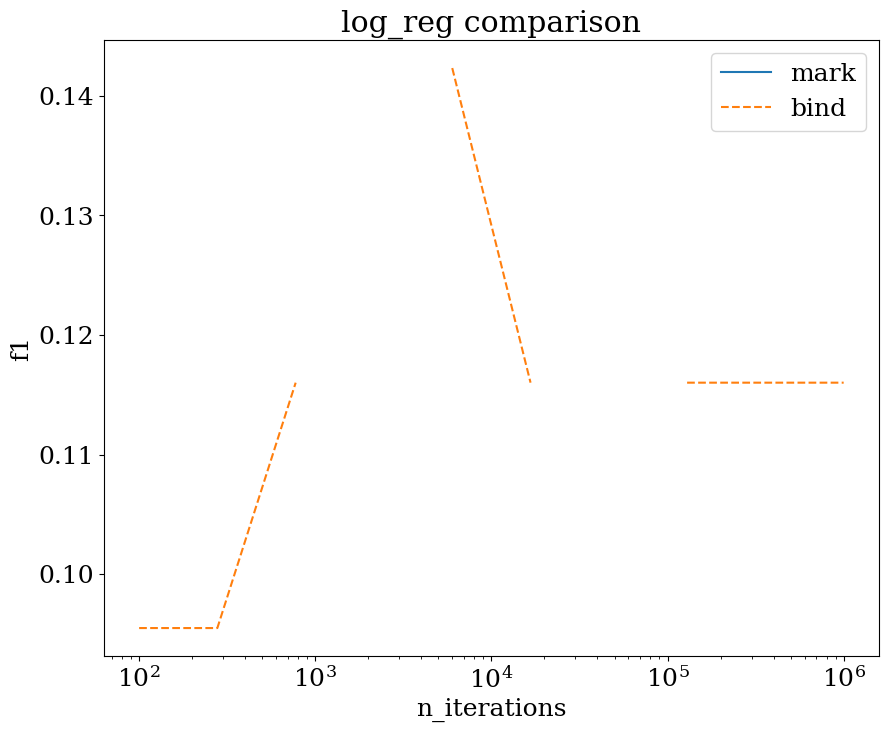

In [179]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(n_iter_arr, f1_arr_mark, label = "mark")
plt.plot(n_iter_arr, f1_arr_bind, label = "bind", linestyle = "--")
plt.xscale("log")
plt.xlabel("n_iterations")
plt.ylabel("f1")
plt.title("log_reg comparison")
plt.legend()
# plt.savefig('f1.png')

<Figure size 640x480 with 0 Axes>

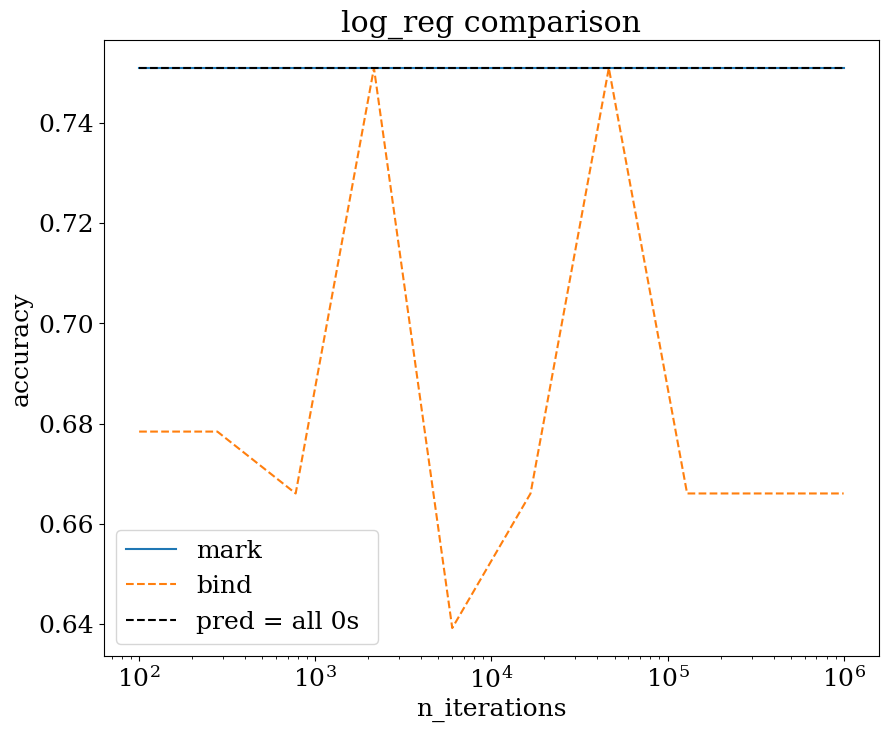

In [188]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(n_iter_arr, acc_arr_mark, label = "mark")
plt.plot(n_iter_arr, acc_arr_bind, label = "bind", linestyle = "--")
plt.hlines(np.sum((s_ij == np.zeros(len(s_ij)))) / len(s_ij), n_iter_arr[0], n_iter_arr[-1], label = "pred = all 0s ", color = "black", linestyle = "--")
plt.xscale("log")
plt.xlabel("n_iterations")
plt.ylabel("accuracy")
plt.title("log_reg comparison")
plt.legend()
# plt.savefig('acc.png')

In [164]:
np.sum((s_ij == np.zeros(len(s_ij)))) / len(s_ij)
# if model just predicts 0 exclusively

0.7509259259259259

In [134]:
A_0_best_mark = best_mark[-1]
A_mat_best_mark = best_mark[0:len(best_mark)-1].reshape(num_marks, num_marks)
b_ij_mark = (sig_mark_i*A_mat_best_mark[0]*sig_mark_i)+A_0_best_mark
f_ij_mark = 1/(1 + np.exp(-b_ij_mark)) #sigmoid
classified_mark = np.zeros(len(f_ij_mark))
classified_mark[f_ij_mark > 0.5] = 1
# BIND confusion matrix
true_pos_mark = np.sum((s_ij == np.ones(len(s_ij))) * (classified_mark == np.ones(len(s_ij))))
true_neg_mark = np.sum((s_ij == np.zeros(len(s_ij))) * (classified_mark == np.zeros(len(s_ij))))
false_pos_mark = np.sum((s_ij == np.zeros(len(s_ij))) * (classified_mark == np.ones(len(s_ij))))
false_neg_mark = np.sum((s_ij == np.ones(len(s_ij))) * (classified_mark == np.zeros(len(s_ij))))

recall_mark = true_pos_mark / (true_pos_mark + false_neg_mark) #sensitivity
precision_mark = true_pos_mark / (true_pos_mark + false_pos_mark) 

f1_mark = (2 * precision_mark * recall_mark) / (precision_mark + recall_mark)
# f1_bind
accuracy_mark = (true_pos_mark + true_neg_mark) / (true_pos_mark + true_neg_mark + false_pos_mark + false_neg_mark)


In [140]:
find_acc_f1(best_mark)

C:\Users\tmhab\AppData\Local\Temp\ipykernel_21516\2682012851.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision_bind  = true_pos_bind  / (true_pos_bind  + false_pos_bind )


(0.7509259259259259, nan)

In [136]:
f1_mark

0.09856630824372761

In [138]:
f1_arr_mark

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

## Locally weighted linear regression

In [386]:
class LocallyWeightedLinearRegression():
    """Locally Weighted Regression (LWR).

    Example usage:
        > clf = LocallyWeightedLinearRegression(tau)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def __init__(self, tau):
        super(LocallyWeightedLinearRegression, self).__init__()
        self.tau = tau
        self.x = None
        self.y = None

    def fit(self, x, y):
        """Fit LWR by saving the training set.

        """
        # *** START CODE HERE ***
        self.x = x #
        self.y = y
        # w = np.zeros(len(x))
        # for i, x_i in enumerate(x):
        #     diff = x - x_i
        #     ssd =  np.sum(diff**2, axis=1) 
        #     w[i] = np.exp( - ssd / (2*0.5**2) )

        # W = np.diag(w)
        # X = x
        
        # XWX_inv = np.linalg.inv(X.T.dot(W.dot(X)))
        
        # # theta = (X^T W X)^-1 X^T W y
        # theta = XWX_inv.dot(X.T.dot(W.dot(y)))
        # return theta
        # *** END CODE HERE ***

    def predict(self, x):
        """Make predictions given inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        
        if self.x is None or self.y is None:
            raise RuntimeError('Must call fit before predict.')

        # *** START CODE HERE ***
        # for each x:
        #     generate all the weights for that x
        #     then generate theta for that x (which minimizes cost function)
        #     then calculate theta^T x- thats the prediction!
        #     save this prediction in an array
        # return predictions
        # print("DATA", x)
        pred_arr = np.zeros(np.shape(x)[0])
        for i in range(np.shape(x)[0]): # for each potential query point
            x_q = x[i,:]
            # generate weights for that query point
            diff = self.x - x_q
            # weights = np.exp(  (- np.sum((self.x-x_q)**2, axis = 1) ) / (2*self.tau**2)   )
            weights = np.sum((self.x-x_q)**2, axis = 1) / (2*self.tau**2)

            #train model
            W = np.diag(weights)
            X = self.x
            XWX_inv = np.linalg.inv(X.T.dot(W.dot(X)))
            
            # theta = (X^T W X)^-1 X^T W y
            theta = XWX_inv.dot(X.T.dot(W.dot(self.y)))
            pred_q = theta.T.dot(x_q)
            # print("theta:",theta)
            # print("x_q", x_q)
            # print(pred_q)
            pred_arr[i] = pred_q

        return pred_arr
        # pass
        # *** END CODE HERE ***

In [388]:
# np.shape(sig_mark_i*sig_mark_j)
x_mark = np.zeros((len(sig_mark_i*sig_mark_j), 2))
x_mark[:,0] = sig_mark_i*sig_mark_j
x_mark[:,1] = 1

x_bind = np.zeros((len(sig_bind_i*sig_bind_j), 2))
x_bind[:,0] = sig_bind_i*sig_bind_j
x_bind[:,1] = 1

y_binary = s_ij
y = Hi_C

In [390]:
from sklearn.model_selection import train_test_split 

In [392]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(x_mark,y ,  
                                   test_size=0.25,  
                                   shuffle=True) 

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(x_bind,y ,  
                                   test_size=0.25,  
                                   shuffle=True) 
  

In [382]:
%%time
tau_array = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
# tau_array = [0.5e-1, 1e-1, 1, 10]
train_acc_m_arr = np.zeros_like(tau_array) - 1
test_acc_m_arr = np.zeros_like(tau_array) - 1
train_acc_b_arr = np.zeros_like(tau_array) - 1
test_acc_b_arr = np.zeros_like(tau_array) - 1

for i, tau in enumerate(tau_array):
    clf_mark = LocallyWeightedLinearRegression(tau)
    clf_mark.fit(X_train_m, y_train_m)
    
    x_eval = X_test_m
    p_eval_m = clf_mark.predict(x_eval)

    clf_bind = LocallyWeightedLinearRegression(tau)
    clf_bind.fit(X_train_b, y_train_b)
    
    x_eval = X_test_b
    p_eval_b = clf_bind.predict(x_eval)

    x_eval = X_train_m
    p_train_eval_m = clf_mark.predict(x_eval)    

    x_eval = X_train_b
    p_train_eval_b = clf_bind.predict(x_eval)
    
    train_acc_m = np.sum((p_train_eval_m - y_train_m)**2)
    train_acc_m_arr[i] = train_acc_m
    test_acc_m = np.sum((p_eval_m - y_test_m)**2)
    test_acc_m_arr[i]= test_acc_m
    train_acc_b = np.sum((p_train_eval_b - y_train_b)**2)
    train_acc_b_arr[i] = train_acc_b
    test_acc_b = np.sum((p_eval_b - y_test_b)**2)
    test_acc_b_arr[i] = test_acc_b
    print("ONE TAU DONE")

ONE TAU DONE
ONE TAU DONE
ONE TAU DONE
ONE TAU DONE
CPU times: total: 6min 12s
Wall time: 8min 14s


<Figure size 640x480 with 0 Axes>

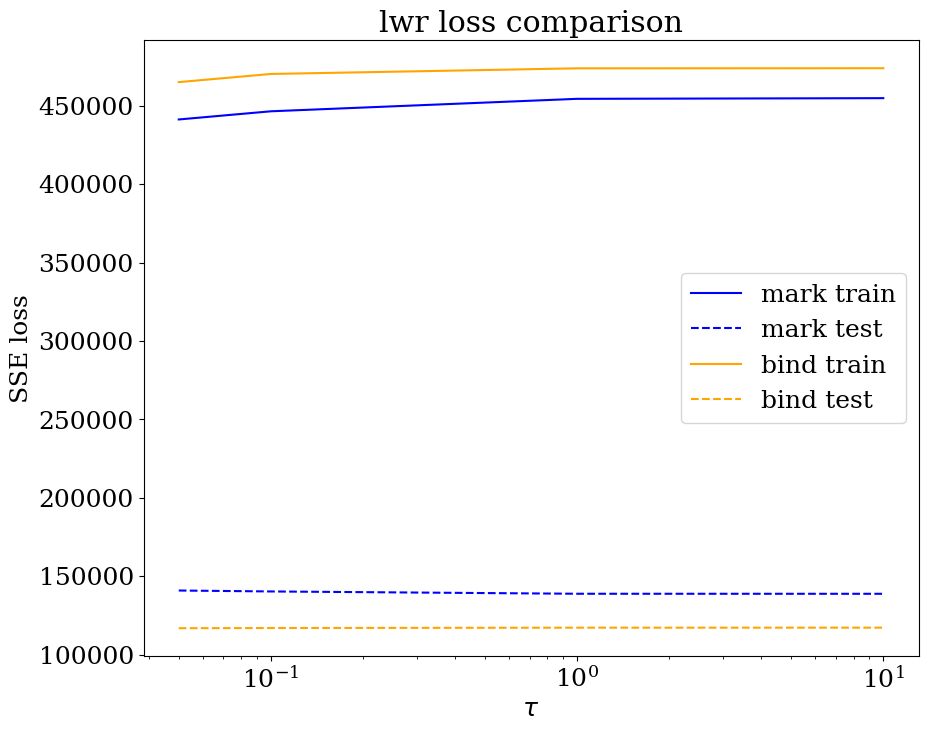

In [383]:
# variance weights
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.xscale("log")

plt.plot(tau_array, train_acc_m_arr, color = "blue", label = "mark train")
plt.plot(tau_array, test_acc_m_arr, color = "blue", linestyle = "--", label = "mark test")

plt.plot(tau_array, train_acc_b_arr, color = "orange", label = "bind train")
plt.plot(tau_array, test_acc_b_arr, color = "orange", linestyle = "--", label = "bind test")

plt.xlabel(r"$\tau$")
plt.ylabel("SSE loss")
plt.title("lwr loss comparison")
plt.legend()

<Figure size 640x480 with 0 Axes>

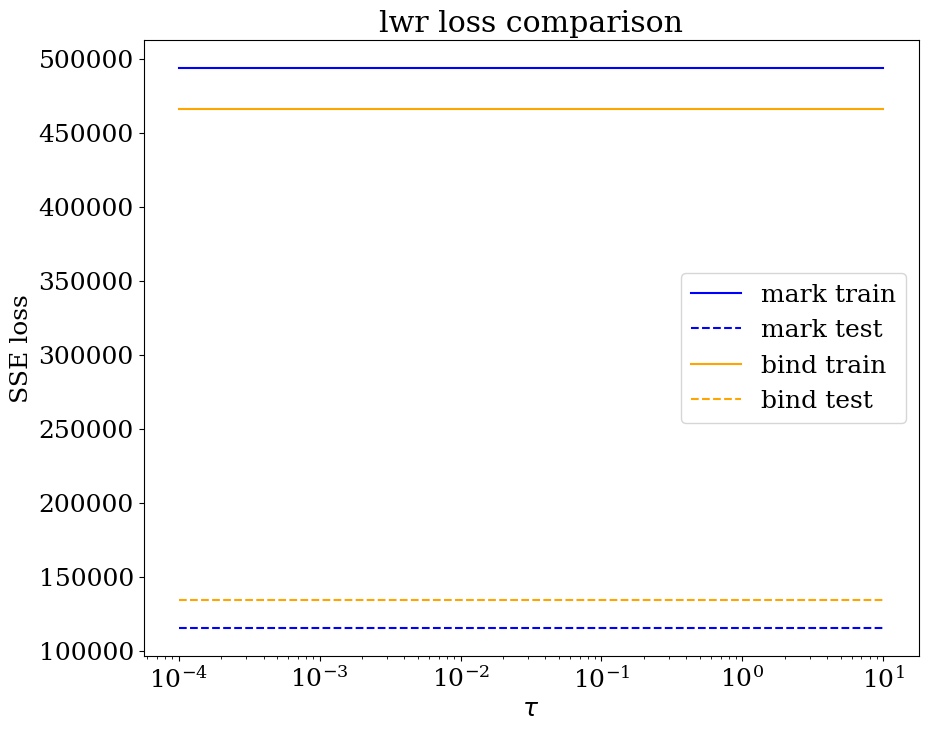

In [344]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.xscale("log")

plt.plot(tau_array, train_acc_m_arr, color = "blue", label = "mark train")
plt.plot(tau_array, test_acc_m_arr, color = "blue", linestyle = "--", label = "mark test")

plt.plot(tau_array, train_acc_b_arr, color = "orange", label = "bind train")
plt.plot(tau_array, test_acc_b_arr, color = "orange", linestyle = "--", label = "bind test")

plt.xlabel(r"$\tau$")
plt.ylabel("SSE loss")
plt.title("lwr loss comparison")
plt.legend()

In [409]:
tau = .1

In [411]:
# %%time
clf_mark = LocallyWeightedLinearRegression(tau)
clf_mark.fit(X_train_m, y_train_m)

x_eval = X_test_m
p_eval_m = clf_mark.predict(x_eval)

In [397]:
%%time
# tau = .01
clf_bind = LocallyWeightedLinearRegression(tau)
clf_bind.fit(X_train_b, y_train_b)

x_eval = X_test_b
p_eval_b = clf_bind.predict(x_eval)

KeyboardInterrupt: 

In [398]:
%%time

x_eval = X_train_m
p_train_eval_m = clf_mark.predict(x_eval)

KeyboardInterrupt: 

In [399]:
%%time

x_eval = X_train_b
p_train_eval_b = clf_bind.predict(x_eval)

KeyboardInterrupt: 

In [ ]:
np.sum((p_train_eval_m - y_train_m)**2)
np.sum((p_eval_m - y_test_m)**2)
np.sum((p_train_eval_b - y_train_b)**2)
np.sum((p_eval_b - y_test_b)**2)

In [303]:
# TRAIN error is WORSE than test error! at tau = 1
# at tau = 0.1: marginally better- not really tho
# at tau = 0.01: same 

In [400]:
print("tau = ", tau)
np.sum((p_train_eval_m - y_train_m)**2) #tau = 0.1

tau =  0.001


447715.87343997485

In [402]:
print("tau = ", tau)

np.sum((p_train_eval_m - y_train_m)**2)

tau =  0.001


447715.87343997485

In [407]:
print("tau = ", tau)

np.sum((p_eval_m - y_test_m)**2)

tau =  0.001


151283.6293369113

In [413]:
print("tau = ", tau)

np.sum((p_eval_m - y_test_m)**2)

tau =  0.1


151283.62933691128

In [315]:
print("tau = ", tau)

np.sum((p_train_eval_b - y_train_b)**2)

tau =  0.1


416554.9047477965

In [235]:
np.sum((p_eval_b - y_test_b)**2)

137455.32854440907

In [ ]:
plt.plot(

In [113]:
# %%time
# tau = 1
# clf_binary = LocallyWeightedLinearRegression(tau)
# clf_binary.fit(X_train_m, y_train_)

# x_eval = x_train_mark
# p_eval_binary = clf_binary.predict(x_eval)


In [119]:
np.sum((p_eval - s_ij)**2)

604.9380945939854

In [ ]:
# reconsrtruct hi c from clf

In [147]:
import seaborn as sns
from matplotlib.colors import LogNorm

In [183]:
np.shape(p_train_eval_m)

(2430,)

In [189]:
2430**0.5

49.29503017546495

In [191]:
p_eval_m_plotting = p_eval_m[:28**2].reshape((28,28))
p_eval_b_plotting = p_eval_b[:28**2].reshape((28,28))
y_test_m_plotting = y_test_m[:28**2].reshape((28,28))
y_test_b_plotting = y_test_b[:28**2].reshape((28,28))

p_train_eval_m_plotting = p_train_eval_m[:49**2].reshape((49,49))
p_train_eval_b_plotting = p_train_eval_b[:49**2].reshape((49,49))
y_train_m_plotting = y_train_m[:49**2].reshape((49,49))
y_train_b_plotting = y_train_b[:49**2].reshape((49,49))
# p_eval_b  y_test_b

<Figure size 640x480 with 0 Axes>

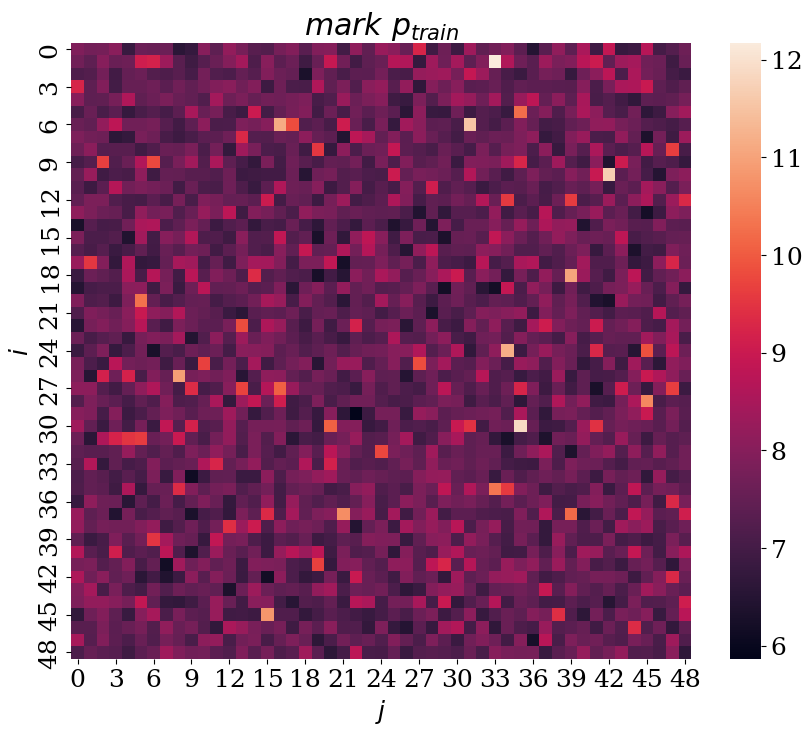

In [319]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


# min_ind = 0
# max_ind = len(mu1_array)
    
# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
ax = sns.heatmap(p_train_eval_m_plotting)#, linewidth=0.25, cmap = "cool", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind],\
                 # cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})#,\
                    # vmin=1/(k_vec[-1]), vmax=1/(k_vec[0]))

# ax.axvline(x=50.5, linewidth=4, color="black", linestyle = "--")
# ax.axhline(y=50.5, linewidth=4, color="black", linestyle = "--")

plt.ylabel("$i$")
plt.xlabel("$j$")
plt.title(r"$mark \ p_{train} $" )#+  ", $\chi = $" + \
          # str(np.round(chi, 2)) \
          # +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          # "\n")


plt.show()


<Figure size 640x480 with 0 Axes>

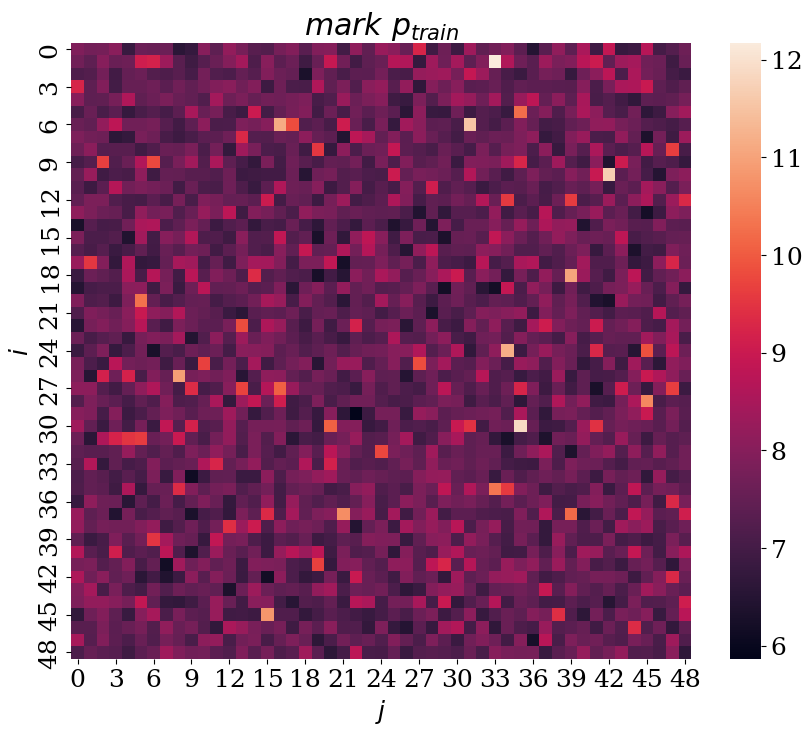

In [321]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


# min_ind = 0
# max_ind = len(mu1_array)
    
# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
ax = sns.heatmap(p_train_eval_m_plotting)#, linewidth=0.25, cmap = "cool", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind],\
                 # cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})#,\
                    # vmin=1/(k_vec[-1]), vmax=1/(k_vec[0]))

# ax.axvline(x=50.5, linewidth=4, color="black", linestyle = "--")
# ax.axhline(y=50.5, linewidth=4, color="black", linestyle = "--")

plt.ylabel("$i$")
plt.xlabel("$j$")
plt.title(r"$mark \ p_{train} $" )#+  ", $\chi = $" + \
          # str(np.round(chi, 2)) \
          # +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          # "\n")


plt.show()


<Figure size 640x480 with 0 Axes>

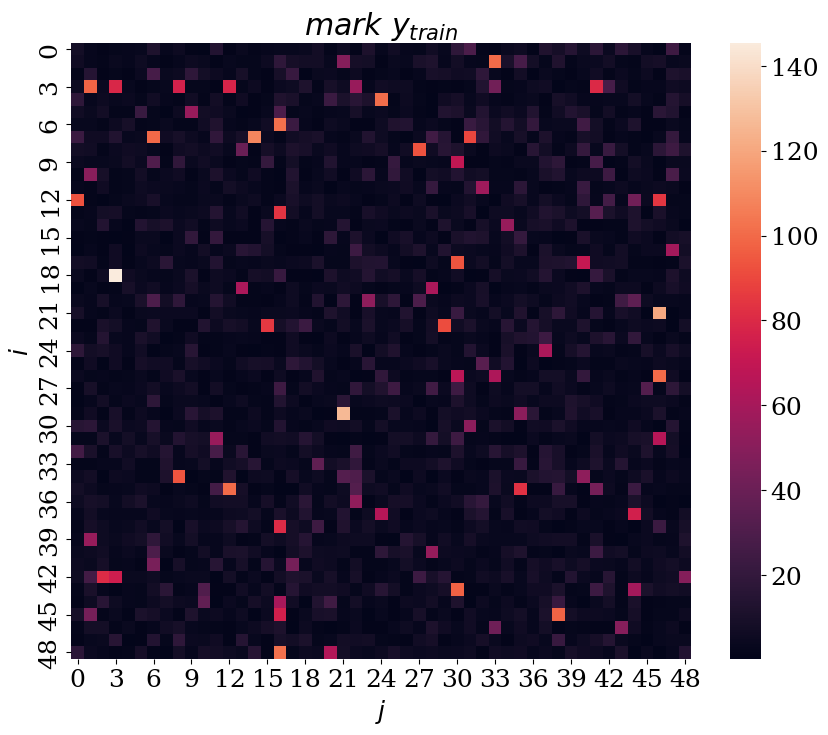

In [323]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


# min_ind = 0
# max_ind = len(mu1_array)
    
# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
ax = sns.heatmap(y_train_m_plotting)#, linewidth=0.25, cmap = "cool", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind],\
                 # cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})#,\
                    # vmin=1/(k_vec[-1]), vmax=1/(k_vec[0]))

# ax.axvline(x=50.5, linewidth=4, color="black", linestyle = "--")
# ax.axhline(y=50.5, linewidth=4, color="black", linestyle = "--")

plt.ylabel("$i$")
plt.xlabel("$j$")
plt.title(r"$mark \ y_{train}$" )#+  ", $\chi = $" + \
          # str(np.round(chi, 2)) \
          # +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          # "\n")


plt.show()


## Neural Net

In [216]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron 
import itertools

In [65]:
assert(binding_resolution == resolution)
nuc_per_bin = int(resolution / (bp_per_nuc)) # nuc per bin.    [resolution] = bp per bin, bp_per_nuc = 200

# generate copy of Hi-c data where genomic position turned into {bin index precursor}
Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
Hi_c_raw_obs_div = Hi_c_raw_obs_div.dropna()
Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs_div["i"].values//resolution).astype(int)
Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs_div["j"].values//resolution).astype(int)

#cutoff last bin so that mark data and hi-c data are same size
cutoff_bin = len(marks_1)//nuc_per_bin
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["i"] != cutoff_bin]
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["j"] != cutoff_bin]

i_combs = Hi_c_raw_obs_div["i"].values
j_combs = Hi_c_raw_obs_div["j"].values
Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

#Turn Hi_C data into binary classification; 1 = contact, 0 = no
s_ij = np.zeros(len(Hi_C))
s_ij[Hi_C > np.mean(Hi_C)] = 1 # Hi_C into binary classification, based on MEDIAN

# # first divide mark data into bins
# mlp_data_mark_1 = marks_1[:(len(marks_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)#.astype(sigma_dt)


# # get average mark signal for each bin
# sig_i_avgd_1 = np.mean(sig_i, axis=1)
# sig_j_avgd_1 = np.mean(sig_j, axis=1)

num_marks = 1

sig_mark_i = mark_1_avgd[i_combs]
sig_mark_j = mark_1_avgd[j_combs]

sig_bind_i = s_bind_hp1_avgd[i_combs] 
sig_bind_j = s_bind_hp1_avgd[j_combs]




### individual model training

In [95]:
# np.shape(sig_mark_i*sig_mark_j)
x_mark = np.zeros((len(sig_mark_i*sig_mark_j), 4))
x_mark[:,0] = sig_mark_i
x_mark[:,1] = sig_mark_j
x_mark[:,2] = i_combs
x_mark[:,3] = j_combs

x_bind = np.zeros((len(sig_bind_i*sig_bind_j), 4))
x_bind[:,0] = sig_bind_i
x_bind[:,1] = sig_bind_j
x_bind[:,2] = i_combs
x_bind[:,3] = j_combs

y_binary = s_ij
y = Hi_C

In [93]:
x_mark

array([[0.61528336, 1.        ],
       [0.5859468 , 1.        ],
       [0.558009  , 1.        ],
       ...,
       [0.9385398 , 1.        ],
       [0.7900452 , 1.        ],
       [0.927369  , 1.        ]])

In [97]:
%%time

# data = mark_mlp_data_fast
# X = data[:,0:-1]
# y = data[:,-1]

X_train_mark, X_test_mark, y_train_mark, y_test_mark = train_test_split(x_mark,y,random_state=1, test_size=0.2)
#train model
mark_SLP_reg = MLPRegressor(hidden_layer_sizes=(200, 100, 50, 25),activation="relu",random_state=1).fit(X_train_mark, y_train_mark)

y_pred=mark_SLP_reg.predict(X_test_mark)

print("resolution = %s" % resolution) 
print("training score:", mark_SLP_reg.score(X_train_mark, y_train_mark))
print("testing score:", mark_SLP_reg.score(X_test_mark, y_test_mark))

resolution = 1000000.0
training score: 0.4117506123771062
testing score: 0.35299561625859865
CPU times: total: 312 ms
Wall time: 3.27 s


In [110]:
# %%time

# # data = mark_mlp_data_fast
# # X = data[:,0:-1]
# # y = data[:,-1]

# X_train_bind, X_test_bind, y_train_bind, y_test_bind = train_test_split(x_bind,y,random_state=1, test_size=0.2)
# #train model
# mark_SLP_reg = MLPRegressor(hidden_layer_sizes=(200, 100, 50, 25),activation="relu",random_state=1).fit(X_train_bind, y_train_bind)

# y_pred=mark_SLP_reg.predict(X_test_mark)

# print("resolution = %s" % resolution) 
# print("training score:", mark_SLP_reg.score(X_train_mark, y_train_mark))
# print("testing score:", mark_SLP_reg.score(X_test_mark, y_test_mark))

resolution = 1000000.0
training score: 0.5356470520983149
testing score: 0.5472053983674936
CPU times: total: 562 ms
Wall time: 4.21 s


In [116]:
%%time

# data = mark_mlp_data_fast
# X = data[:,0:-1]
# y = data[:,-1]

X_train_bind, X_test_bind, y_train_bind, y_test_bind = train_test_split(x_bind,y,random_state=1, test_size=0.2)
#train model
hls = (400, 200, 100, 50)
bind_SLP_reg = MLPRegressor(hidden_layer_sizes=hls,activation="relu",random_state=1).fit(X_train_bind, y_train_bind)

y_pred=bind_SLP_reg.predict(X_test_mark)

print("resolution = %s" % resolution) 
print("training score:", bind_SLP_reg.score(X_train_bind, y_train_bind))
print("testing score:", bind_SLP_reg.score(X_test_bind, y_test_bind))

resolution = 1000000.0
training score: 0.48753026034131564
testing score: 0.41260363041400283
CPU times: total: 812 ms
Wall time: 6.78 s


### 1D array model training

In [132]:
hls_array = [(400), (400, 200), (400, 200, 100), (400, 200, 100, 50), (400, 200, 100, 50, 25)]
test_mark_arr = np.zeros(len(hls_array))
train_mark_arr = np.zeros(len(hls_array))
test_bind_arr = np.zeros(len(hls_array))
train_bind_arr = np.zeros(len(hls_array))

X_train_bind, X_test_bind, y_train_bind, y_test_bind = train_test_split(x_bind,y,random_state=1, test_size=0.2)
X_train_mark, X_test_mark, y_train_mark, y_test_mark = train_test_split(x_mark,y,random_state=1, test_size=0.2)

for h, hls in enumerate(hls_array):
    #train model
    bind_SLP_reg = MLPRegressor(hidden_layer_sizes=hls,activation="relu",random_state=1).fit(X_train_bind, y_train_bind)
    
    # y_pred=bind_SLP_reg.predict(X_test_mark)
    train_bind_arr[h] = bind_SLP_reg.score(X_train_bind, y_train_bind)
    test_bind_arr[h] = bind_SLP_reg.score(X_test_bind, y_test_bind)

    mark_SLP_reg = MLPRegressor(hidden_layer_sizes=hls,activation="relu",random_state=1).fit(X_train_mark, y_train_mark)
    
    # y_pred=mark_SLP_reg.predict(X_test_mark)
    train_mark_arr[h] = mark_SLP_reg.score(X_train_mark, y_train_mark)
    test_mark_arr[h] =  mark_SLP_reg.score(X_test_mark, y_test_mark)

Text(0.5, 1.0, '$n_{1} = 400$, res = 1000000.0')

<Figure size 640x480 with 0 Axes>

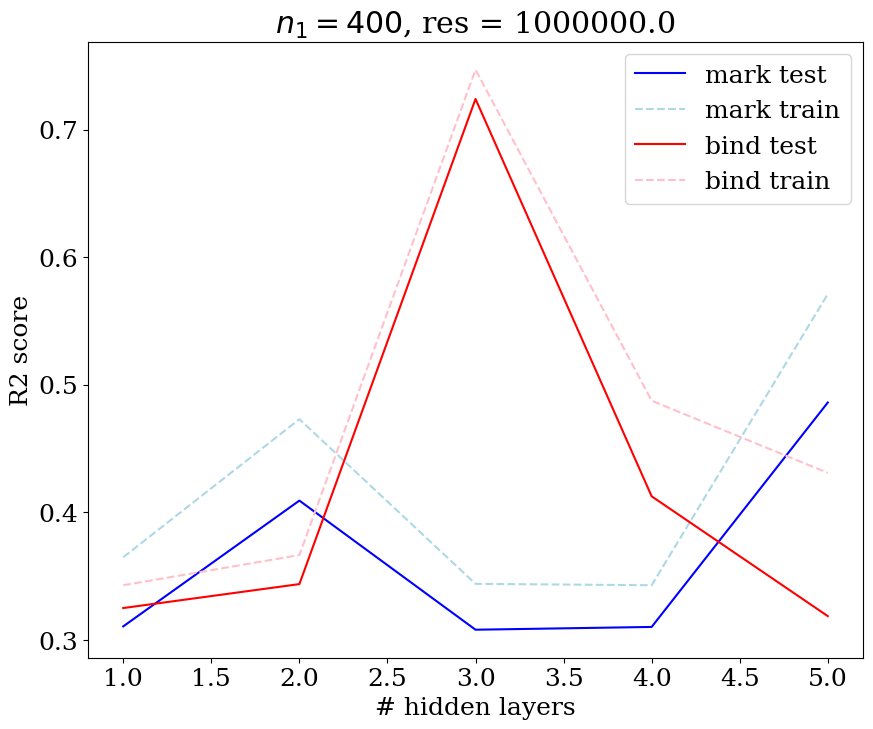

In [174]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

layer_size_arr = np.arange(1,6)
plt.plot(layer_size_arr, test_mark_arr, label = "mark test", color = "blue")
plt.plot(layer_size_arr, train_mark_arr, linestyle = "--", label = "mark train", color = "lightblue")
plt.plot(layer_size_arr, test_bind_arr, linestyle = "-", label = "bind test", color = "red")
plt.plot(layer_size_arr, train_bind_arr, linestyle = "--", label = "bind train", color = "pink")
plt.legend()

plt.xlabel('# hidden layers')
plt.ylabel('R2 score')
plt.title(r"$n_{1} = 400$, res = %s" % resolution)

### 2D array model training

In [204]:
nl = 400
L = 5
np.arange(nl,0,-nl/2)

array([400., 200.])

In [206]:
nl // (2 ** np.arange(L))

array([400, 200, 100,  50,  25], dtype=int32)

In [196]:
int(hls)

100

In [ ]:
%%time
nl_array = np.arange(100,500, 100) #number of neurons in first hidden layer
L_array = np.arange(1,5) #number of hidden layers
n_ave = 3 # number of neural nets to average over

R2_arr_bind_train = np.zeros((len(nl_array), len(L_array)))
R2_arr_bind_test = np.zeros((len(nl_array), len(L_array)))
R2_arr_mark_train = np.zeros((len(nl_array), len(L_array)))
R2_arr_mark_test = np.zeros((len(nl_array), len(L_array)))

for i, nl in enumerate(nl_array):
    for j, L in enumerate(L_array):
        # get hidden layer architecture from nl, L
        hls = nl // (2 ** np.arange(L)) # L elements, nl is first, divide by 2 each subsequent layer
        print("nl = %s, L = %s" % (nl, L))
        for n in range(n_ave):
            #reshuffle test and train
            X_train_bind, X_test_bind, y_train_bind, y_test_bind = train_test_split(x_bind,y, test_size=0.2)
            X_train_mark, X_test_mark, y_train_mark, y_test_mark = train_test_split(x_mark,y, test_size=0.2)   

            
            #train *n_ave* neural nets, add R2 score to rolling average
            bind_SLP_reg = MLPRegressor(hidden_layer_sizes=hls,activation="relu",random_state=1).fit(X_train_bind, y_train_bind)
            print("bind model trained")

            R2_arr_bind_train[i,j] += (1/n_ave) * bind_SLP_reg.score(X_train_bind, y_train_bind)
            R2_arr_bind_test[i,j] += (1/n_ave) * bind_SLP_reg.score(X_test_bind, y_test_bind)

            
            mark_SLP_reg = MLPRegressor(hidden_layer_sizes=hls,activation="relu",random_state=1).fit(X_train_mark, y_train_mark)
            print("mark model trained")

            R2_arr_mark_train[i,j] += (1/n_ave) * mark_SLP_reg.score(X_train_mark, y_train_mark)
            R2_arr_mark_test[i,j] += (1/n_ave) * mark_SLP_reg.score(X_test_mark, y_test_mark)        

nl = 100, L = 1


C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


bind model trained
mark model trained


C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


bind model trained
mark model trained


C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


bind model trained


C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mark model trained
nl = 100, L = 2
bind model trained
mark model trained
bind model trained
mark model trained
bind model trained
mark model trained
nl = 100, L = 3
bind model trained
mark model trained
bind model trained
mark model trained


C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


bind model trained
mark model trained
nl = 100, L = 4
bind model trained


C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mark model trained
bind model trained
mark model trained
bind model trained
mark model trained
nl = 200, L = 1


C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


bind model trained
mark model trained
bind model trained
mark model trained
bind model trained


C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mark model trained
nl = 200, L = 2
bind model trained
mark model trained
bind model trained
mark model trained
bind model trained
mark model trained
nl = 200, L = 3
bind model trained
mark model trained
bind model trained
mark model trained
bind model trained
mark model trained
nl = 200, L = 4
bind model trained
mark model trained
bind model trained
mark model trained
bind model trained
mark model trained
nl = 300, L = 1
bind model trained
mark model trained
bind model trained
mark model trained
bind model trained
mark model trained
nl = 300, L = 2
bind model trained
mark model trained
bind model trained
mark model trained


In [ ]:
np.max(R2_arr_bind_train)

In [ ]:
np.max(R2_arr_bind_test)

In [ ]:
np.max(R2_arr_mark_train)

In [ ]:
np.max(R2_arr_mark_test)

In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# f_gam_soln_arr = density_maps

# #protein 1
ax = sns.heatmap(R2_arr_bind_train, linewidth=0., cmap = "winter", xticklabels=nl_array, yticklabels=L_array, cbar_kws={'label':  r'$ R^2 $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

spacing = 1
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(np.round(nl_array,0))#.astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(L_array[::spacing],0))#.astype(np.int64))

# ax.axhline(y=60, linewidth=4, color="white", linestyle = "--")
# ax.axhline(y=37, linewidth=4, color="white", linestyle = "--")

plt.xlabel('$n_1$')
plt.ylabel('$L$')
plt.title(r"$R2 map bind train$, res = %s, n_ave = %s" % (resolution, n_ave))
plt.show()


<Figure size 640x480 with 0 Axes>

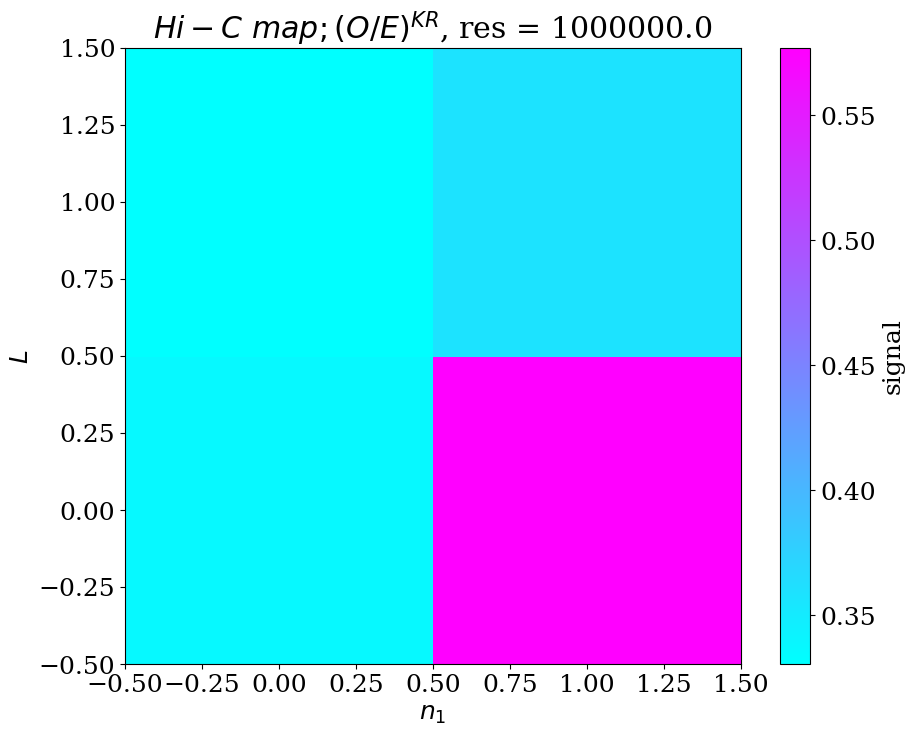

In [220]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
# heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r"$(O/E)^{KR}$")

# 2. Plot the heatmap using imshow
plt.imshow(R2_arr_bind_train, cmap="cool", interpolation='nearest', origin='lower')
 xticklabels=mu2_array, yticklabels=mu1_array
# Add color bar to indicate intensity values
plt.colorbar(label='signal')

ax = sns.heatmap(fa_mat, linewidth=0., cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})

# 3. Add labels and title
plt.xlabel('$n_1$')
plt.ylabel('$L$')
plt.title(r"$Hi-C \ map; (O/E)^{KR}$, res = %s" % resolution)

# Show the plot
plt.show()

In [224]:
R2_arr_bind_test

array([[0.32644765, 0.51356759],
       [0.3184068 , 0.31852804]])

In [226]:
R2_arr_mark_test

array([[0.36494526, 0.46534695],
       [0.32647235, 0.46847417]])

In [156]:
np.arange(1,6)

array([1, 2, 3, 4, 5])

In [ ]:
# average results for many nerual nets
# change exact form of hidden layers

# PLAY with resolution

In [ ]:
# %%time

# data = bind_mlp_data_fast
# X = data[:,0:-1]
# y = data[:,-1]

# X_train_bind, X_test_bind, y_train_bind, y_test_bind = train_test_split(X,y,random_state=1, test_size=0.2)
# #train model
# bind_SLP_reg = MLPRegressor(hidden_layer_sizes=(100),activation="relu",random_state=1).fit(X_train_bind, y_train_bind)

# y_pred=bind_SLP_reg.predict(X_test_bind)

# print("training score:", bind_SLP_reg.score(X_train_bind, y_train_bind))
# print("testing score:", bind_SLP_reg.score(X_test_bind, y_test_bind))

## Convolution Neural Net